# 剛体のキネマティクス II

前項では、**オイラー角**・**DCM**を用いた剛体の姿勢表現について学んだ。本稿では、以下の姿勢パラメータを用いた姿勢表現について学んでいこう。

- **Principal Rotation Vectors**
- **クォータニオン（オイラーパラメータ）**
- **Classical Rodrigues Parameters**
- **Modified Rodrigues Parameters**
- **Stereographic Orientation Parameters**

:::{admonition} 項目 
:class: note
- 3.1) Principal Rotation Vector
- 3.2) クォータニオン（オイラーパラメータ）
- 3.3) Classical Rodorigues Parameter
- 3.3) Modified Rodorigues Parameter
:::

:::{admonition} 目的 
:class: tip
- 各種試製パラメータの定義・性質を理解する。
- 各種姿勢パラメータの相互変換を理解する。
- 各種姿勢パラメータの利点・欠点を整理し、場合に応じて適切に使い分けられるようになる。
- 各種姿勢パラメータを用いた演算を実施できるようになる。
- 時間経過に伴う姿勢パラメータ変化を数値積分を用いて求める。
:::

---

In [2]:
# Import Relevant Libraries
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

# Functions from Module 2 Notebook (that are being re-used)

In [2]:
'''
The definitions of Rotation Matrices
--------------------------------------------------------------------------------------------------------------------------------------------------------
    - The rotation abt the 1st principle axis (x-axis) is defined by the angle 'psi'
    - The rotation abt the 2nd principle axis (y-axis) is defined by the angle 'theta'
    - The rotation abt the 3rd principle axis (z-axis) is defined by the angle 'phi'
'''

def rotation_matrix_x(phi, transformation_type='passive'):
    """Generate rotation matrix for a roll (rotation about the x-axis).
    
    Args:
        phi (float): The angle of rotation in degrees.
        transformation_type (str): Specifies the type of transformation, 'passive' (default) or 'active'.
    
    Returns:
        numpy.ndarray: The rotation matrix for x-axis rotation.
    """
    phi = np.radians(phi)
    c, s = np.cos(phi), np.sin(phi)
    matrix = np.array([[1, 0, 0], 
                       [0, c, s], 
                       [0, -s, c]])
    if transformation_type == 'active':
        return matrix.T
    return matrix

def rotation_matrix_y(theta, transformation_type='passive'):
    """Generate rotation matrix for a pitch (rotation about the y-axis).
    
    Args:
        theta (float): The angle of rotation in degrees.
        transformation_type (str): Specifies the type of transformation, 'passive' (default) or 'active'.
    
    Returns:
        numpy.ndarray: The rotation matrix for y-axis rotation.
    """
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    matrix = np.array([[c, 0, -s], 
                       [0, 1, 0], 
                       [s, 0, c]])
    if transformation_type == 'active':
        return matrix.T
    return matrix

def rotation_matrix_z(psi, transformation_type='passive'):
    """Generate rotation matrix for a yaw (rotation about the z-axis).
    
    Args:
        psi (float): The angle of rotation in degrees.
        transformation_type (str): Specifies the type of transformation, 'passive' (default) or 'active'.
    
    Returns:
        numpy.ndarray: The rotation matrix for z-axis rotation.
    """
    psi = np.radians(psi)
    c, s = np.cos(psi), np.sin(psi)
    matrix = np.array([[c, s, 0], 
                       [-s, c, 0], 
                       [0, 0, 1]])
    if transformation_type == 'active':
        return matrix.T
    return matrix

In [3]:
def initialize_ref_frame(fig, frame_matrix, frame_label, colors, is_static=False):
    """
    Initializes vectors on the provided Plotly figure as either static or dynamic using a color dictionary.

    Args:
        fig (plotly.graph_objects.Figure): The figure to which the frame vectors will be added.
        frame_matrix (np.ndarray): A 3x3 matrix representing the orientation of the frame, where each column is a unit vector (i, j, k).
        frame_label (str): The base label for the frame vectors ('N' for the N-frame, 'E' for the E-frame).
        colors (dict): A dictionary specifying the colors for each vector, keyed by 'i', 'j', 'k'.
        is_static (bool, optional): If True, the frame will be added as static (with dotted lines). 
                                    If False, it will be added as dynamic (with solid lines). 
                                    Defaults to False.

    Returns:
        list: A list of trace indices added to the figure.

    Note:
        - This function modifies the provided `fig` object in place by adding traces representing the frame vectors. It does not return a new figure.
        - The `line_style` is set to 'dot' for static frames and 'solid' for dynamic frames to visually distinguish between them.
        - The function uses the `frame_matrix` to extract the vectors corresponding to the axes (i, j, k) 
          and assigns the specified colors from the `colors` dictionary.
        - The `frame_label` is appended with a suffix to indicate whether the frame is static or dynamic.
        - The `trace_indices` list stores the indices of the added traces. 
          The `len(fig.data) - 1` expression is used to get the index of the most recently added trace, 
          as `len(fig.data)` gives the total number of traces in the figure, and subtracting 1 gives the index of the last added trace.

    Example:
        colors = {'i': 'red', 'j': 'green', 'k': 'blue'}
        frame_matrix = np.eye(3)
        fig = go.Figure()
        trace_indices = initialize_ref_frame(fig, frame_matrix, 'N', colors, is_static=True)
        print(trace_indices)  # Output should be [0, 1, 2] for the first call
    """
    line_style = 'dot' if is_static else 'solid'
    
    suffix = " (static)" if is_static else ""
    
    axis_labels = ['i', 'j', 'k'] 

    trace_indices = []

    for i, axis in enumerate(axis_labels):
        vec = frame_matrix[i, :]
        name = f'{frame_label}_{axis}{suffix}'
        color = colors[axis]  # Access color using axis label as key
        trace = go.Scatter3d(x=[0, vec[0]], 
                             y=[0, vec[1]], 
                             z=[0, vec[2]],
                             mode='lines+markers', 
                             name=name,
                             marker=dict(color=color),
                             line=dict(dash=line_style, color=color))
        fig.add_trace(trace)

        trace_indices.append(len(fig.data)-1)

    return trace_indices

def setup_animation_scene(fig, frames, title):
    """
    Configures animation controls and layout settings for a Plotly figure.

    Args:
        fig (plotly.graph_objects.Figure): The figure to which the controls will be added.
        frames (list): List of animation frames to be included in the slider control.
        title (str): The title to set for the animation scene.

    Notes:
        - Animation Controls: Adds interactive controls for playing and stepping through animation frames.
        - Button Configuration: 'Play' button starts the animation immediately with smooth transitions.
        - Slider Mechanism: Slider allows navigation to specific frames for detailed examination.
        - Current Value Display: Displays the current frame number during the animation.
        - Layout Configuration: Ensures a fixed aspect ratio and consistent spatial references.
        - Scene Dimensions: Sets dimensions for comfortable viewing.
        - Usability and Interactivity: Enhances the visualization's effectiveness for presentations and educational purposes.
    """
    # Define the 'Play' button
    play_button = {"label": 'Play',
                   "method": 'animate',
                   "args": [None, {"frame": {"duration": 100, "redraw": True},
                                   "fromcurrent": True,
                                   "mode": 'immediate'}]}

    # Define the slider steps
    slider_steps = [{"method": 'animate',
                     "args": [[f.name], {"mode": 'immediate',
                                         "frame": {"duration": 100, "redraw": True},
                                         "fromcurrent": True}],
                     "label": str(k)} for k, f in enumerate(frames)]

    # Update the figure layout with animation controls and scene settings
    fig.update_layout(updatemenus=[{"type": "buttons",
                                    "showactive": False,
                                    "y": -0.13,
                                    "x": -0.02,
                                    "xanchor": 'left',
                                    "yanchor": 'bottom',
                                    "buttons": [play_button]}],
                      sliders=[{"steps": slider_steps,
                                "x": 0.1,
                                "y": 0,
                                "currentvalue": {"visible": True, "prefix": 'Step: '}}],
                      width=1000,
                      height=800,
                      template='presentation',
                      scene={"aspectmode": 'cube',
                             "xaxis": {"range": [-1, 1], "autorange": False},
                             "yaxis": {"range": [-1, 1], "autorange": False},
                             "zaxis": {"range": [-1, 1], "autorange": False}},
                      title=title)

## 3.1) Principal Rotation Vectors

### 3.1.1) - オイラーの回転定理

````{prf:theorem} オイラーの回転定理
:label: euler-theorem
物体の任意回転は、ある一軸周りの回転で表すことができる
````
このオイラーの回転定理における回転軸を **主軸(Principal Rotation Vector)** と呼ぶことにする。
このとき、回転後の座標系$\mathcal{B}$と回転前の座標系$\mathcal{N}$の両方において、主軸$\hat{e}$は同じベクトル成分を持つため、

$$
\hat{e} = e_{b1} \hat{b}_1 + e_{b2} \hat{b}_2 + e_{b3} \hat{b}_3 \\
$$

$$
\hat{e} = e_{n1} \hat{n}_1 + e_{n2} \hat{n}_2 + e_{n3} \hat{n}_3 \\
$$
とおくと、
$$
e_{bi} = e_{ni} = e_i
$$
が成り立つ。
回転行列 $[C]$ を用いることで、$\mathcal{B}$ 座標系および $\mathcal{N}$ 座標系における $\hat{e}$ の座標成分は以下の関係を持つ。

$$
\begin{bmatrix}
e_1 \\
e_2 \\
e_3
\end{bmatrix}
=
[C]
\begin{bmatrix}
e_1 \\
e_2 \\
e_3
\end{bmatrix}
$$

**<ins>固有ベクトルとしての主軸</ins>**<br>
式　から、$\hat{e}$ は回転行列 $[C]$ の固有値 +1 に対応する固有ベクトルであることが明らかである。したがって、回転行列 $[C]$が固有値 +1を持つことが分かれば、オイラーの定理を示すことができる。$[C]$ の固有値を $\lambda$ とおくと、特性方程式は

$$
\left|C-\lambda I\right|=0
$$

となる。$[C]$が$3\times3$の直交行列であること利用すると、

$$
-(\lambda-1)\left\{\lambda^2-\left(\operatorname{tr} C-1\right) \lambda+1\right\}=0
$$
と整理される。確かに$[C]$は固有値+1を持つため、オイラーの定理が示された。

なお、回転は以下の 4 通りが考えられる。

1. $(\hat{e}, \Phi)$
2. $(-\hat{e}, -\Phi)$
3. $(\hat{e}, \Phi')$
4. $(-\hat{e}, -\Phi')$

ここで、$\Phi' = \Phi - 2\pi$ である。



### 3.1.2) - DCMとの関係性

**<ins>DCM と Principal Rotation Vectors(PRV) の関係</ins>**<br>
$[C]$ は 回転軸成分$e_1, e_2, e_3$・回転角$\Phi$を用いて次のように表現できる。

$$
[C] = \begin{bmatrix}
e_1^2 \Sigma + c\Phi & e_1e_2 \Sigma + e_3s\Phi & e_1e_3 \Sigma - e_2s\Phi \\
e_2e_1 \Sigma - e_3s\Phi & e_2^2 \Sigma + c\Phi & e_2e_3 \Sigma + e_1s\Phi \\
e_3e_1 \Sigma + e_2s\Phi & e_3e_2 \Sigma - e_1s\Phi & e_3^2 \Sigma + c\Phi
\end{bmatrix}
$$

ここで、$\Sigma = 1 - c\Phi$, $s\Phi = \sin{\Phi}$, $c\Phi = \cos{\Phi}$ である。
これは、[ロドリゲスの回転公式](https://ja.wikipedia.org/wiki/%E3%83%AD%E3%83%89%E3%83%AA%E3%82%B2%E3%82%B9%E3%81%AE%E5%9B%9E%E8%BB%A2%E5%85%AC%E5%BC%8F)と呼ばれている。


逆変換として、$[C]$ から PRV を求めると、

$$
\cos\Phi = \frac{1}{2} (C_{11} + C_{22} + C_{33} - 1)
$$

$$
\hat{e} 
=
\begin{bmatrix}
e_1 \\
e_2 \\
e_3
\end{bmatrix}
=
\frac{1}{2\sin\Phi}
\begin{bmatrix}
C_{23} - C_{32} \\
C_{31} - C_{13} \\
C_{12} - C_{21}
\end{bmatrix}
$$

ただし、$\Phi' = \Phi - 2\pi$ である。



**問題1. DCMとPRVの相互変換**<br>
DCM→PRV、PRV→DCMの変換を行う関数をそれぞれ実装せよ。

In [16]:
def prv_to_rotation_matrix(e, phi_deg):
    """
    Converts a Principal Rotation Vector (PRV) to a rotation matrix.

    Args:
        e (np.array)   : The unit vector of the PRV.
        phi_deg (float): The rotation angle of the PRV in degrees.

    Returns:
        np.array: A 3x3 rotation matrix.
    """
    # Convert the angle from degrees to radians
    phi_rad = np.radians(phi_deg)
    
    # Calculate the cosine and sine of the angle
    c_phi = np.cos(phi_rad)
    s_phi = np.sin(phi_rad)
    
    # Calculate the matrix Sigma
    Sigma = 1 - c_phi

    # Ensure e is a float array to avoid UFuncTypeError during in-place operations
    e = np.array(e, dtype=float)
    
    # Normalize e vector to ensure it's a valid unit vector
    e /= np.linalg.norm(e)
    
    # Decompose the unit vector into its components
    e1, e2, e3 = e
    
    # Construct the rotation matrix using the given formula
    C = np.array([[((e1**2)*Sigma + c_phi), (e1*e2*Sigma + e3*s_phi), (e1*e3*Sigma - e2*s_phi)],
                  [(e2*e1*Sigma - e3*s_phi), ((e2**2)*Sigma + c_phi), (e2*e3*Sigma + e1*s_phi)],
                  [(e3*e1*Sigma + e2*s_phi), (e3*e2*Sigma - e1*s_phi), ((e3**2)*Sigma + c_phi)]])

    return C

In [17]:
def rotation_matrix_to_prv(C):
    """
    Converts a rotation matrix to a Principal Rotation Vector (PRV).

    Args:
        C (np.array): A 3x3 rotation matrix.

    Returns:
        tuple: A PRV represented as (e_vector, phi_angle).
    """
    # Compute the angle phi from the trace of the rotation matrix
    trace_C = np.trace(C)
    phi = np.arccos((trace_C - 1) / 2)
    
    # Handle edge cases where phi is 0 or π
    if np.isclose(phi, 0) or np.isclose(phi, np.pi):
        
        # For phi=0, no rotation, the axis can be arbitrary, choose x-axis for simplicity
        # For phi=π, rotation by 180 degrees, find axis by identifying non-zero component
        e = np.array([1, 0, 0])  # Arbitrary axis, could also check for non-diagonal elements
    
    else:
        # Compute the unit vector e from the off-diagonal elements of the matrix C
        e = (1 / (2 * np.sin(phi))) * np.array([C[1, 2] - C[2, 1],
                                                C[2, 0] - C[0, 2],
                                                C[0, 1] - C[1, 0]])
        # Normalize the unit vector to ensure it's a valid unit vector
        e /= np.linalg.norm(e)

    # Ensure the angle phi is in the range [0, 2*pi)
    phi = np.mod(phi, 2 * np.pi)
    phi = np.rad2deg(phi)

    return e, phi

**問題2. PRVからDCMへの変換**<br>
任意の回転を表すPRVは以下の2種類が存在した。

1. $(\hat{e}, \Phi)$
2. $(-\hat{e}, -\Phi)$

適当な$\hat{e}$, $\Phi$を与え、2種類のPRVをDCMに変換したものが一致することを確認せよ。

In [18]:
'''
Concept check on PRV and DCM Relation - Question 4
Given the PRV and Angle, check if the DCMs are all equal
'''
c = prv_to_rotation_matrix(np.array([1,0,0]), 30)
print(c)
print('--------------------------------------')

c_1 = prv_to_rotation_matrix(np.array([-1,0,0]), -30)
print(c_1)

[[ 1.         0.         0.       ]
 [ 0.         0.8660254  0.5      ]
 [ 0.        -0.5        0.8660254]]
--------------------------------------
[[ 1.        -0.         0.       ]
 [ 0.         0.8660254  0.5      ]
 [-0.        -0.5        0.8660254]]


**問題3. DCMからPRVへの変換**<br>
問題2で算出したDCMをPRVに変換し、元のPRVに一致することを確認せよ。

In [19]:
C = np.array([[ 1, 0, 0],
              [0, 0.8660254, 0.5],
              [0, -0.5, 0.8660254]])

e, phi = rotation_matrix_to_prv(C)
print(f"PRV:\t{e}")
print(f"Phi:\t{phi}")

PRV:	[1. 0. 0.]
Phi:	30.00000043366474


### 3.1.3) - PRV における加減算

$\Phi_1$ および $\Phi_2$ をそれぞれ最初および 2 番目の PRV の回転角度とし、$\hat{e}_1$ および $\hat{e}_2$ は対応する主回転軸の単位ベクトルであるとする。合成された PRV が、$\Phi$ および $\hat{e}$ によって表されるとき、加減算を以下のように定義する。

**加算**：
$\Phi_1$, $\hat{e}_1$, $\Phi_2$, $\hat{e}_2$ を用いて、$\Phi$ および $\hat{e}$を表現すること。 

**減算**：
$\Phi$, $\hat{e}$, $\Phi_1$, $\hat{e}_1$ を用いて、$\Phi_2$, $\hat{e}_2$ を表現すること。

※ $\Phi_1$, $\hat{e}_1$ も同様に表現できる。

**<ins>PRV の加算</ins>**<br>

2 つの PRV を加算する方法には以下がある。

- **DCM Method**:
  合成された回転行列は、2 つの回転行列の積として求められる。
  $$
  [FN(\Phi, \hat{e})] = [FB(\Phi_2, \hat{e}_2)] [BN(\Phi_1, \hat{e}_1)]
  $$

- **Direct Method**:
  合成された PRV の角度および軸は次の式で求められる。

  $$
  \Phi = 2 \cos^{-1} \left( \cos \frac{\Phi_1}{2} \cos \frac{\Phi_2}{2} - \sin \frac{\Phi_1}{2} \sin \frac{\Phi_2}{2} \hat{e}_1 \cdot \hat{e}_2 \right)
  $$

  $$
  \hat{e} = \frac{ \cos \frac{\Phi_2}{2} \sin \frac{\Phi_1}{2} \hat{e}_1 + \cos \frac{\Phi_1}{2} \sin \frac{\Phi_2}{2} \hat{e}_2 + \sin \frac{\Phi_1}{2} \sin \frac{\Phi_2}{2} \hat{e}_1 \times \hat{e}_2 }{\sin \frac{\Phi}{2}}
  $$

**<ins>PRV の減算</ins>**<br>

PRVの減算も同様に2つの方法がある。

- **DCM Method**:
  $$
  [FB(\Phi_2, \hat{e_2})] = [FN(\Phi, \hat{e})] [BN(\Phi_1, \hat{e}_1)]^T
  $$

- **Direct Method**:
  
  $$
  \Phi_2 = 2 \cos^{-1} \left( \cos \frac{\Phi}{2} \cos \frac{\Phi_1}{2} + \sin \frac{\Phi}{2} \sin \frac{\Phi_1}{2} \hat{e} \cdot \hat{e}_1 \right)
  $$

  $$
  \hat{e}_2 = \frac{1}{\sin \frac{\Phi_2}{2}}
  \left(
  \cos \frac{\Phi_1}{2} \sin \frac{\Phi}{2} \hat{e}
  - \cos \frac{\Phi}{2} \sin \frac{\Phi_1}{2} \hat{e}_1
  + \sin \frac{\Phi}{2} \sin \frac{\Phi_1}{2} \hat{e} \times \hat{e}_1
  \right)
  $$

ここで、$\Phi_1$ および $\Phi_2$ はそれぞれ最初および 2 番目の PRV の回転角度を表し、$\hat{e}_1$ および $\hat{e}_2$ は対応する主回転軸の単位ベクトルである。合成された PRV は、$\Phi$ および $\hat{e}$ によって表される。




### 3.1.4 - PRV のキネマティクス微分法方程式

**<ins>角速度ベクトルと PRV 速度のマッピング</ins>**<br>

- **剛体の角速度ベクトルから PRV 速度へのマッピング**:

  $$
  \dot{\gamma} = \left[ I_{3 \times 3} + \frac{1}{2} \left[ \tilde{\gamma} \right] + \frac{1}{\Phi^2} \left( 1 - \frac{\Phi}{2} \cot \left( \frac{\Phi}{2} \right) \right) \left[ \tilde{\gamma} \right]^2 \right] \omega_{B}
  $$

- **PRV 速度から剛体の角速度ベクトルへのマッピング**:

  $$
  \omega_{B} = \left[ I_{3 \times 3} - \left( 1 - \cos \Phi \right) \frac{1}{\Phi^2} \left[ \tilde{\gamma} \right] + \left( \Phi - \sin \Phi \right) \frac{1}{\Phi^3} \left[ \tilde{\gamma} \right]^2 \right] \dot{\gamma}
  $$


## 3.2) クォータニオン

**クォータニオン**（**オイラーパラメータ**とも呼ばれる）は、3 次元空間における回転を表現するための数体系である。クォータニオンを利用することで、オイラー角を使用する際に発生する **ジンバルロック** のような特異点を回避しながら、回転を記述することができる。クォータニオンは、計算効率の高さから、宇宙機・ロボティクスの姿勢制御などの分野で広く利用されている。

**<ins>歴史的経緯</ins>**

- **レオンハルト・オイラー（1776）**: [オイラー](https://ja.wikipedia.org/wiki/%E3%83%AC%E3%82%AA%E3%83%B3%E3%83%8F%E3%83%AB%E3%83%88%E3%83%BB%E3%82%AA%E3%82%A4%E3%83%A9%E3%83%BC)は **オイラーの回転定理** を提唱し、**任意の 3D 回転は、特定の軸の周りでの 1 回の回転として表現できる** ことを数学的に示した。この定理は、3D 回転の概念を単一の軸角表現に単純化するものだったが、ベクトルの実際の回転を行う方法については示されていなかった。　

- **オランダ・ロドリゲス（1840）**: [ロドリゲス](https://en.wikipedia.org/wiki/Olinde_Rodrigues)はオイラーの研究を発展させ、**ロドリゲスの回転公式** として知られる幾何学的な公式を提案した。これは、ある軸を中心に特定の角度でベクトルを回転させる際の計算方法を提供し、オイラーの抽象的な定理を実用的に応用できるようにした。

- **ウィリアム・ローワン・ハミルトン（1843）**: [ハミルトン](https://ja.wikipedia.org/wiki/%E3%82%A6%E3%82%A3%E3%83%AA%E3%82%A2%E3%83%A0%E3%83%BB%E3%83%AD%E3%83%BC%E3%83%AF%E3%83%B3%E3%83%BB%E3%83%8F%E3%83%9F%E3%83%AB%E3%83%88%E3%83%B3)は、オイラー・ロドリゲスパラメータを拡張した **クォータニオン** を開発した。クォータニオンは、実数 1 つと 3 つの虚数成分から構成され、次のように表される。

  $$ q = a + bi + cj + dk $$

  ここで、\(a, b, c, d\) は実数であり、\(i, j, k\) は虚数単位である。クォータニオンは 3D 回転の記述にとどまらず、数学や物理学における広範な代数体系の一部である。しかし、姿勢ダイナミクスにおいては、**ジンバルロックを回避しながら効率的に回転を計算する手段** として活用される。クォータニオンはスムーズで安定した 3D 回転を可能にするため、宇宙機制御や 3D コンピュータグラフィックスなどの分野で不可欠な技術となっている。


**<ins>オイラー、ロドリゲス、ハミルトンの比較</ins>**

- **オイラー（1776）** は **有限回転定理** によって、3D 回転が単一の軸の周りで発生することを示したが、これはあくまで概念的な枠組みであった。
  
- **ロドリゲス（1840）** は、オイラーの理論を具体化し、**ロドリゲスの回転公式** を用いて **ベクトルを回転させる実際の計算方法** を提供した。

- **ハミルトン（1843）** は、**クォータニオン** というより一般的な代数構造を開発し、その一部を 3D 回転の表現に応用した。クォータニオンは回転の計算を効率化し、計算上の曖昧さを解消する点で極めて有用である。




### 3.2.1 - クォータニオン の定義・性質

**<ins>定義</ins>**  
**クォータニオン**（オイラーパラメータとも呼ばれる）は、オイラー角における特異点の問題を回避しながら、三次元空間における回転を表現できる。クォータニオンは以下のように定義される。

- $\beta_0 = \cos(\frac{\phi}{2})$
- $\beta_1 = e_1 \sin(\frac{\phi}{2})$
- $\beta_2 = e_2 \sin(\frac{\phi}{2})$
- $\beta_3 = e_3 \sin(\frac{\phi}{2})$

ここで、$\phi$ は回転角、$e_1, e_2, e_3$ は回転軸に沿った単位ベクトルの成分であり、この単位ベクトルが回転軸の方向を定義する。
なお、スカラー部$\cos(\frac{\phi}{2})$ を第4成分とする表現形式もあり、どちらを採用するかは流派によるが、本稿では上記の定義を採用する。

**<ins>制約条件</ins>**  
オイラー パラメータが有効であるためには、以下の制約を満たす必要がある。

- すべてのオイラー パラメータの二乗和が 1 であること:
  $$
  \beta_0^2 + \beta_1^2 + \beta_2^2 + \beta_3^2 = 1
  $$

この条件により、すべてのオイラー パラメータは四次元単位超球面上に拘束されることになる。



<div align="center">
  <img src="Images/q-hypersphere.jpg" alt="Alt text" width="300"/>
</div>

**<ins>PRV との関係とクォータニオンの一意性</ins>**<br>
クォータニオン と主回転ベクトル (PRV) はどちらも 3D 空間での姿勢を表現であり、相互に関係が深い姿勢パラメータである。

- **クォータニオン:** 以下の成分によって定義される。
  - $\beta_0 = \cos(\phi/2)$
  - $\beta_i = e_i \sin(\phi/2)$ （$i=1,2,3$）
  これは、単位ベクトル軸 $e_1, e_2, e_3$ によって定義される回転軸と回転角 $\phi$ によって表現される。<br><br>
- **主回転ベクトル (PRV):** 回転軸と回転角を直接使用して回転を定義する。しかし、クォータニオン と同様に記述は一意ではなく、同じ姿勢に対して 4 通りの異なる表現が可能である。このことは、回転表現に固有の非一意性を示している。

クォータニオン と PRV は、次の 2 つの等価な方法で同じ回転を表すことができる。

1. **正回転と逆回転:**
   - $(e, \phi)$ による回転は、$(-e, -\phi)$ による回転と等価である。これは、ある軸周りの回転が、逆方向の軸周りの逆回転と等価であることから分かる。
   - オイラー パラメータの観点では:
     - $\beta_0' = \cos(-\phi/2) = \cos(\phi/2) = \beta_0$
     - $\beta_i' = -e_i \sin(-\phi/2) = e_i \sin(\phi/2) = \beta_i$ （$i=1,2,3$）<br><br>
2. **代替表現:**
   - もう一つの表現として、$\phi' = \phi - 2\pi$ を考慮することで、同じ姿勢を達成するための遠回りな経路を記述することができる。
   - EP の場合:
     - $\beta_0' = \cos(\phi/2 - \pi) = -\cos(\phi/2) = -\beta_0$
     - $\beta_i' = e_i \sin(\phi/2 - \pi) = -e_i \sin(\phi/2) = -\beta_i$



### 3.2.2 - DCMとの関係

**<ins>クォーとニオンと方向余弦行列 (DCM) の関係</ins>**<br>

3次元空間における回転を表現する上で、クォータニオン と方向余弦行列 (DCM) の関係は基本的なものです。ロドリゲスの回転公式を用いると、DCMは以下のようにクォータニオンを用いて直接表現することができる。

$$
C = \begin{bmatrix}
\beta_0^2 + \beta_1^2 - \beta_2^2 - \beta_3^2 & 2(\beta_1\beta_2 - \beta_0\beta_3) & 2(\beta_1\beta_3 - \beta_0\beta_2) \\
2(\beta_1\beta_2 - \beta_0\beta_3) & \beta_0^2 - \beta_1^2 + \beta_2^2 - \beta_3^2 & 2(\beta_2\beta_3 + \beta_0\beta_1) \\
2(\beta_1\beta_3 + \beta_0\beta_2) & 2(\beta_2\beta_3 - \beta_0\beta_1) & \beta_0^2 - \beta_1^2 - \beta_2^2 + \beta_3^2
\end{bmatrix}
$$

一方、DCMからクォータニオンを抽出する逆の関係は以下の通りです。ただし、$\beta_0 \rightarrow 0$ の場合、特異点を避けるための注意が必要である。

$$
\beta_0 = \pm \frac{1}{2} \sqrt{C_{11} + C_{22} + C_{33} + 1}
$$
$$
\beta_1 = \frac{C_{23} - C_{32}}{4\beta_0}, \quad \beta_2 = \frac{C_{31} - C_{13}}{4\beta_0}, \quad \beta_3 = \frac{C_{12} - C_{21}}{4\beta_0}
$$

<br><br>

**<ins>回転行列からクォータニオン を計算するシェパード法</ins>**<br>

シェパード法は、与えられた方向余弦行列 (DCM) $C$ からクォータニオン を正確に導出するための手法である。この方法は、計算誤差を引き起こす可能性のある小さい数での除算を避け、数値的安定性を確保するために2つの主要なステップから成る。

**_Step 1: クォータニオン各成分の二乗を計算する_**

まず、クォータニオンの各成分の中で最も大きな値を持つものを決定する。これは計算上の不安定性を回避するために不可欠な操作である。

- **$\beta_0$ の二乗**:
  
  $$
  \beta_0^2 = \frac{1 + \text{trace}(C)}{4}
  $$

- **$\beta_1$ の二乗**:
  
  $$
  \beta_1^2 = \frac{1 + 2C_{11} - \text{trace}(C)}{4}
  $$

- **$\beta_2$ の二乗**:
  
  $$
  \beta_2^2 = \frac{1 + 2C_{22} - \text{trace}(C)}{4}
  $$

- **$\beta_3$ の二乗**:
  
  $$
  \beta_3^2 = \frac{1 + 2C_{33} - \text{trace}(C)}{4}
  $$

**_Step 2: 残りのクォータニオン成分を計算する_**

最も大きな $\beta_{i}^2$ を特定した後、その値を基準として、下式を元に残りの成分を算出する。


  $$
  \beta_0\beta_1 = \frac{(C_{23} - C_{32})}{4}
  $$
  $$
  \beta_0\beta_2 = \frac{(C_{31} - C_{13})}{4}
  $$
  $$
  \beta_0\beta_3 = \frac{(C_{12} - C_{21})}{4}
  $$

  $$
  \beta_1\beta_2 = \frac{(C_{12} + C_{21})}{4}
  $$
  $$
  \beta_1\beta_3 = \frac{(C_{13} + C_{31})}{4}
  $$
  $$
  \beta_2\beta_3 = \frac{(C_{23} + C_{32})}{4}
  $$

この手法によって、数値的な安定性を担保しながら、DCMからクォータニオンを計算できる。

**問題4. クォータニオン・DCMの相互変換**<br>
クォータニオンからDCMに、DCMからクォータニオンに変換する関数を実装せよ。
なお、クォータニオンの正規化および特異点処理に注意すること。

In [21]:
def quaternion_to_DCM(q):
    """
    Converts a quaternion to a direction cosine matrix (DCM).

    Args:
        q (np.array): A numpy array of size 4 (a row vector) representing the quaternion,
                      where q[0] is the scalar part (beta_0), and q[1], q[2], q[3] are the 
                      vector parts (beta_1, beta_2, beta_3).

    Returns:
        np.array: A 3x3 rotation matrix (DCM).

    Example:
        >>> q = np.array([1, 5, 6, 2])
        >>> quaternion_to_DCM(q)
        array([[ 0.38461538, -0.07692308,  0.91923077],
               [ 0.07692308,  0.99230769, -0.09615385],
               [-0.91923077,  0.09615385,  0.38461538]])
    """
    # Ensure q is a float array to maintain precision
    q = np.array(q, dtype=np.float64)
    
    # Check that the holonomic constraint of quaternion is satisfied, else normalize it
    q_norm = np.linalg.norm(q)
    if not np.isclose(q_norm, 1.0, atol=1e-8):
        q /= q_norm
    
    # Extract components
    q0, q1, q2, q3 = q
    
    # Compute the elements of the DCM
    C = np.array([
        [q0**2 + q1**2 - q2**2 - q3**2, 2 * (q1*q2 + q0*q3),         2 * (q1*q3 - q0*q2)],
        [2 * (q1*q2 - q0*q3),           q0**2 - q1**2 + q2**2 - q3**2, 2 * (q2*q3 + q0*q1)],
        [2 * (q1*q3 + q0*q2),           2 * (q2*q3 - q0*q1),           q0**2 - q1**2 - q2**2 + q3**2]
    ])
    
    return C

# Example usage:
q = np.array([-1, 5, 6, 2])
C = quaternion_to_DCM(q)
print("Direction Cosine Matrix (DCM):\n", C)

Direction Cosine Matrix (DCM):
 [[-0.21212121  0.84848485  0.48484848]
 [ 0.96969697  0.12121212  0.21212121]
 [ 0.12121212  0.51515152 -0.84848485]]


In [22]:
def DCM_to_quaternion(dcm):
    """
    Converts a Direction Cosine Matrix (DCM) to a quaternion using a method to ensure robustness against numerical issues.
    
    Args:
        dcm (np.array): A 3x3 rotation matrix (DCM).
    
    Returns:
        np.array: A quaternion represented as a numpy array of size 4, with the scalar component as the first element.
    
    Example Usage:
        >>> dcm = np.array([[-0.21212121, 0.96969697, 0.12121212],
                            [0.84848485, 0.12121212, 0.51515152],
                            [0.48484848, 0.21212121, -0.84848485]])
        >>> quaternion = DCM_to_quaternion(dcm)
        >>> print(quaternion)
    
    Notes:
    - If the scalar component (q0) is negative, it is flipped to positive. (Ensuring shortes path of rotation)
    - Corresponding vector component is also flipped when q0 is flipped. (Shepperd's Method)
    - Flipping maintains the quaternion's correct rotational encoding.
    - Ensures the quaternion represents a rotation of less than 180 degrees.
    - Adheres to quaternion algebra for accurate 3D rotation representation.
    """
    trace = np.trace(dcm)
    q_squared = np.zeros(4)
    q_squared[0] = (1.0 + trace) / 4.0
    q_squared[1] = (1.0 + 2 * dcm[0, 0] - trace) / 4.0
    q_squared[2] = (1.0 + 2 * dcm[1, 1] - trace) / 4.0
    q_squared[3] = (1.0 + 2 * dcm[2, 2] - trace) / 4.0

    q = np.zeros(4)
    max_index = np.argmax(q_squared)

    if max_index == 0:
        q[0] = np.sqrt(q_squared[0])
        q[1] = (dcm[1, 2] - dcm[2, 1]) / (4 * q[0])
        q[2] = (dcm[2, 0] - dcm[0, 2]) / (4 * q[0])
        q[3] = (dcm[0, 1] - dcm[1, 0]) / (4 * q[0])
    
    elif max_index == 1:
        q[1] = np.sqrt(q_squared[1])
        q[0] = (dcm[1, 2] - dcm[2, 1]) / (4 * q[1])
        if q[0] < 0:
            q[0] = -q[0]
            q[1] = -q[1]
        q[2] = (dcm[0, 1] + dcm[1, 0]) / (4 * q[1])
        q[3] = (dcm[2, 0] + dcm[0, 2]) / (4 * q[1])
        
    elif max_index == 2:
        q[2] = np.sqrt(q_squared[2])
        q[0] = (dcm[2, 0] - dcm[0, 2]) / (4 * q[2])
        if q[0] < 0:
            q[0] = -q[0]
            q[2] = -q[2]
        q[1] = (dcm[0, 1] + dcm[1, 0]) / (4 * q[2])
        q[3] = (dcm[1, 2] + dcm[2, 1]) / (4 * q[2])

    elif max_index == 3:
        q[3] = np.sqrt(q_squared[3])
        q[0] = (dcm[0, 1] - dcm[1, 0]) / (4 * q[3])
        if q[0] < 0:
            q[0] = -q[0]
            q[3] = -q[3]
        q[1] = (dcm[2, 0] + dcm[0, 2]) / (4 * q[3])
        q[2] = (dcm[1, 2] + dcm[2, 1]) / (4 * q[3])
    
    return q

# Example Usage
dcm = np.array([[-0.21212121,  0.84848485,  0.48484848],
                [ 0.96969697,  0.12121212,  0.21212121],
                [ 0.12121212,  0.51515152, -0.84848485]])
quaternion = DCM_to_quaternion(dcm)
print(quaternion)

[ 0.12309149 -0.61545746 -0.73854895 -0.24618298]


In [18]:
# Concept Check 5, 6 - Question 1
q = np.array([0.235702, 0.471405, -0.471405, 0.707107])
C = quaternion_to_DCM(q)
print("Direction Cosine Matrix (DCM):\n", C)

Direction Cosine Matrix (DCM):
 [[-0.44444488 -0.11111228  0.88888975]
 [-0.77777842 -0.44444488 -0.44444535]
 [ 0.44444535 -0.88888975  0.11111039]]


In [23]:
# Concept Check 5, 6 - Question 3
BN = np.array([[-0.529403, -0.467056,  0.708231],
               [-0.474115, -0.529403, -0.703525],
               [ 0.703525, -0.708231,  0.0588291]])
quaternion1 = DCM_to_quaternion(BN)
print(quaternion1)

[ 0.00242542  0.48506963 -0.48506963  0.72760482]


In [24]:
# Concept Check 5, 6 - Question 4
#R =  np.matmul(rotation_matrix_x(-10), np.matmul(rotation_matrix_y(10), rotation_matrix_z(20)))
R = rotation_matrix_x(-10) @ rotation_matrix_y(10) @ rotation_matrix_z(20)
Euler_parameter = DCM_to_quaternion(R)
print(Euler_parameter)

NameError: name 'rotation_matrix_x' is not defined

### 3.2.3 - クォータニオンの加減算

**クォータニオンの加算と減算**

クォータニオンの加減算はDCMに変換することなく直接計算できる。この操作は行列形式で以下のように表現される。

$$
\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3 
\end{bmatrix}
=
\begin{bmatrix}
\beta_0'' & -\beta_1'' & -\beta_2'' & -\beta_3'' \\
\beta_1'' & \beta_0'' & \beta_3'' & -\beta_2'' \\
\beta_2'' & -\beta_3'' & \beta_0'' & \beta_1'' \\
\beta_3'' & \beta_2'' & -\beta_1'' & \beta_0''
\end{bmatrix}
\cdot
\begin{bmatrix}
\beta_0' \\
\beta_1' \\
\beta_2' \\
\beta_3'
\end{bmatrix}
$$

または

$$
\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3 
\end{bmatrix}
=
\begin{bmatrix}
\beta_0'' & \beta_1'' & \beta_2'' & \beta_3'' \\
-\beta_1'' & \beta_0'' & -\beta_3'' & \beta_2'' \\
-\beta_2'' & \beta_3'' & \beta_0'' & -\beta_1'' \\
-\beta_3'' & -\beta_2'' & \beta_1'' & \beta_0''
\end{bmatrix}
\cdot
\begin{bmatrix}
\beta_0' \\
\beta_1' \\
\beta_2' \\
\beta_3'
\end{bmatrix}
$$

この行列演算により、2組のクォータニオンが表す回転操作を加算できる。ここで、プライム ( ' ) とダブルプライム ( '' ) は、それぞれ異なる回転を表す。

また、クォータニオンで表現された2つの回転を減算するためには、4x4行列の直交性を利用して逆行列を求め、$\beta''$または$\beta'$のいずれかを直接解く方法が用いられる。


**問題5. クォータニオンの加減算**<br>
回転 $[BN]$, $[FB]$ を表すクォータニオンがそれぞれ、

$$
\begin{bmatrix}
\beta_0' \\
\beta_1' \\
\beta_2' \\
\beta_3' 
\end{bmatrix}
=
\begin{bmatrix}
0.774597 \\
0.258199 \\
0.516398 \\
0.258199 
\end{bmatrix}
$$

$$
\begin{bmatrix}
\beta_0'' \\
\beta_1'' \\
\beta_2'' \\
\beta_3'' 
\end{bmatrix}
=
\begin{bmatrix}
0.359211 \\
0.898027 \\
0.179605 \\
0.179605 
\end{bmatrix}
$$

と表されるとする。上記の加算の公式を用いて、回転$[FN]$に相当するクォータニオンを求めよ。

また、各クォータニオンをDCMに変換して回転$[FN]$を求めた後、クォータニオンに逆変換して、加算公式により算出したクォータニオンと一致することを確かめよ。

In [25]:
# Concept Check 7 - Question 1

# Given quaternions
beta_BN = np.array([0.774597, 0.258199, 0.516398, 0.258199])
beta_FB = np.array([0.359211, 0.898027, 0.179605, 0.179605])

dcm_BN = quaternion_to_DCM(beta_BN)
dcm_FB = quaternion_to_DCM(beta_FB)

dcm_FN = np.matmul(dcm_FB, dcm_BN)
beta_FN = DCM_to_quaternion(dcm_FN)
print(beta_FN)

[ 0.09274743 -0.8347305  -0.51011334  0.18549616]


In [31]:
def addEP(b1,b2):
    """
    addEP(B1,B2)

    	Q = addEP(B1,B2) provides the Euler parameter vector
    	which corresponds to performing to successive
    	rotations B1 and B2.
    """

    q = np.zeros(4)
    q[0] = b2[0]*b1[0]-b2[1]*b1[1]-b2[2]*b1[2]-b2[3]*b1[3];
    q[1] = b2[1]*b1[0]+b2[0]*b1[1]+b2[3]*b1[2]-b2[2]*b1[3];
    q[2] = b2[2]*b1[0]-b2[3]*b1[1]+b2[0]*b1[2]+b2[1]*b1[3];
    q[3] = b2[3]*b1[0]+b2[2]*b1[1]-b2[1]*b1[2]+b2[0]*b1[3];
    if not q[0] >=0:
        q = -q
    return q;

q = addEP(beta_BN, beta_FB)
print(q)

[ 0.0927474  -0.83473077 -0.51011318  0.1854961 ]


In [22]:
# Concept Check 7 - Question 2

# Define the quaternions
beta_FN = np.array([0.359211, 0.898027, 0.179605, 0.179605])
beta_BN = np.array([-0.377964, 0.755929, 0.377964, 0.377964])

dcm_FN = quaternion_to_DCM(beta_FN)
dcm_BN = quaternion_to_DCM(beta_BN)

dcm_FB = np.matmul(dcm_FB, dcm_BN.T)
beta_FB = DCM_to_quaternion(dcm_FB)
print(beta_FB)

[ 6.78844282e-01 -6.10959882e-01 -4.07306295e-01  1.98358998e-07]


### 3.2.4 - クォータニオンのキネマティクス微分方程式

**オイラー・パラメータの微分運動学方程式**

オイラー・パラメータ (EP) の微分運動学方程式は、方向余弦行列 (DCM) と EP との関係から導かれます。これらの方程式の導出過程は複雑ですが、最終的な結果は非常にエレガントで有用であり、特に宇宙船の姿勢推定などの推定理論の応用において重要です。

**双線形微分方程式形式**

EP の運動学的微分方程式は、以下のようなコンパクトな双線形形式で表現できます:

$$
\begin{align*}
\frac{d}{dt}\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3 
\end{bmatrix} = \frac{1}{2} \begin{bmatrix}
\beta_0 & -\beta_1 & -\beta_2 & -\beta_3 \\
\beta_1 & \beta_0 & -\beta_3 & \beta_2 \\
\beta_2 & \beta_3 & \beta_0 & -\beta_1 \\
\beta_3 & -\beta_2 & \beta_1 & \beta_0 
\end{bmatrix} \begin{bmatrix}
0 \\
\omega_1 \\
\omega_2 \\
\omega_3 
\end{bmatrix}
\end{align*}
$$

**別の斜対称行列形式**

また、微分方程式は斜対称行列を用いて再定式化することもでき、これにより数値積分での応用性が向上します:

$$
\begin{align*}
\frac{d}{dt}\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3 
\end{bmatrix} = \frac{1}{2} \begin{bmatrix}
0 & -\omega_1 & -\omega_2 & -\omega_3 \\
\omega_1 & 0 & \omega_3 & -\omega_2 \\
\omega_2 & -\omega_3 & 0 & \omega_1 \\
\omega_3 & \omega_2 & -\omega_1 & 0 
\end{bmatrix} \begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3 
\end{bmatrix}
\end{align*}
$$

この斜対称行列は逆行列を持たないため、EP の定式化において回転軸に対して垂直な角速度の性質が保持されるという特性が強調されます。

これらの定式化は、理論的な発展にとどまらず、カルマンフィルタを用いた宇宙船姿勢推定などの実用的な応用の基盤ともなっており、微分方程式が EP に線形依存していることを示しています。


**オイラー・パラメータ微分運動学方程式の第二形**

オイラー・パラメータは、角速度ベクトルと相互作用する特殊な行列を用いて微分することができ、数値積分の計算を簡略化します:

$$
\dot{\beta} = \frac{1}{2} [B(\beta)]\omega
$$

ここで、$[B(\beta)]$ は次のように定義されます:

$$
[B(\beta)] = \begin{bmatrix}
-\beta_1 & -\beta_2 & -\beta_3 \\
\beta_0 & -\beta_3 & \beta_2 \\
\beta_3 & \beta_0 & -\beta_1 \\
-\beta_2 & \beta_1 & \beta_0 
\end{bmatrix}
$$

**行列 $[B(\beta)]$ の特性**

行列 $[B(\beta)]$ は、以下の2つの重要な恒等式を満たします:

1. **トレースがゼロ**:
   - この特性は、行列が斜対称であることを示しており、これは回転運動における角速度ベクトルの特性と一致します。

2. **直交性の保持**:
   - $[B(\beta)]$ とその転置行列の積がゼロ行列になることは、行列が回転軸に対して角速度の直交性を保持していることを意味し、これは剛体力学において重要な側面です。

**推定理論における重要性**

- **線形依存性**: 微分方程式がオイラー・パラメータに線形依存しているため、カルマンフィルタを用いた宇宙船の姿勢システムなどの推定タスクに最適です。この線形性により、フィルタ内での更新および予測が容易になり、正確なリアルタイム姿勢推定が実現されます。

これらの方程式とその行列表現は、航空宇宙分野における堅牢な姿勢推定システムの開発のための基盤ツールを提供します。


**制御応用におけるオイラー・パラメータの微分運動学方程式 第3形**

制御応用では、姿勢を表現する際の役割が異なるため、オイラー・パラメータのスカラー成分とベクトル成分を個別に扱うことが有益です。

**定義**

- **ベクトル成分**:  
  ベクトル $\epsilon = (\beta_1, \beta_2, \beta_3)^T$ は、クォータニオンの虚数成分を表します。

- **スカラー成分**:  
  スカラー $\beta_0$ は、クォータニオンの実数成分を表します。

**行列表現**

クォータニオンのスカラー部分とベクトル部分の相互作用を扱うために、変換行列 $[T(\beta_0, \epsilon)]$ が定義されます:

$$
[T(\beta_0, \epsilon)] = \beta_0[I_{3 \times 3}] + [\epsilon]
$$

ここで、$[\epsilon]$ はベクトル成分の斜対称行列表現を示します。

**微分方程式**

- **スカラー部分の変化率**:  
  スカラー部分の変化率は次式で与えられます:

  $$
  \dot{\beta_0} = -\frac{1}{2} \epsilon^T \omega = -\frac{1}{2} \omega^T \epsilon
  $$

  この式は、角速度がクォータニオンのスカラー部分の変化率に及ぼす影響を示しており、姿勢のベクトル成分への依存性を浮き彫りにしています。

- **ベクトル部分の変化率**:  
  ベクトル部分の変化率は角速度によって直接影響を受けます:

  $$
  \dot{\epsilon} = \frac{1}{2} [T] \omega
  $$

  この関係は、正確な姿勢制御が求められるシステム、例えば航空宇宙工学などにおいて極めて重要であり、角速度が直接、姿勢の変化率と結び付くことを示しています。


**運動学方程式の直感的理解**

オイラー・パラメータの微分方程式の双線形形式は、角速度の影響下で、姿勢を表すクォータニオンの成分が時間とともにどのように変化するかを数学的に記述したものと見なすことができます。クォータニオンの成分と角速度との間の行列積は、角運動を直接クォータニオン空間へと変換します。これにより、姿勢の瞬間的な変化率を計算することが可能となり、これは宇宙船の動力学のリアルタイムシミュレーションや制御などのタスクにおいて極めて重要です。双線形形式におけるオメガ行列の最初の行に現れるゼロは、クォータニオンのスカラー部分（回転角度の半分の余弦を表す）が角速度に直接寄与しないことを意味しており、クォータニオン表現におけるスカラー成分とベクトル成分の幾何学的な分離を反映しています。

より簡単に言えば、宇宙空間で回転する物体を想像してください。クォータニオンは、単に回転速度に基づくだけでなく、現在の姿勢に基づいてその成分を調整します。この連動性により、クォータニオンの更新が物理的な回転と同期し、他の回転表現に伴う特異点や曖昧さから解放された、滑らかで連続的な回転運動が実現されます。

**実用上の重要性**

- 微分方程式においてスカラー成分とベクトル成分を個別に扱うことにより、航空宇宙分野でのより繊細な制御および推定戦略が可能となります。
- これらの方程式は、衛星姿勢制御システムなど、正確な姿勢調整を要求されるアルゴリズムの実装において基礎となるものです。

このアプローチは、航空宇宙工学のような高精度な環境において、クォータニオンに基づく制御システムの理解と実装のための明確な枠組みを提供します。


In [23]:
# Concept Check 8 - Q1

# Define the initial quaternion and time parameters
q = np.array([0.408248, 0., 0.408248, 0.816497])
t_final = 42
dt = 0.01  # time step for the integration

# Euler integration for the quaternion
for t in np.arange(0, t_final, dt):
    
    angular_vel = np.array([np.sin(0.1 * t), 0.01, np.cos(0.1 * t)]) * np.deg2rad(20)
    
    # Construct the quaternion multiplication matrix
    Q = np.array([
        [q[0], -q[1], -q[2], -q[3]],
        [q[1],  q[0], -q[3],  q[2]],
        [q[2],  q[3],  q[0], -q[1]],
        [q[3], -q[2],  q[1],  q[0]]
    ])

    omega_vectrix = np.insert(angular_vel, 0, 0)
    
    # Compute the quaternion derivative using the quaternion multiplication matrix
    q_dot = 0.5 * np.matmul(Q, omega_vectrix)
    
    # Update the quaternion by integrating q_dot
    q += q_dot * dt

    # Normalize the quaternion to avoid numerical drift
    q /= np.linalg.norm(q)

# Compute the norm of the vector part of the quaternion at t = 42 seconds
norm_vector_part = np.linalg.norm(q[1:])
print(f"The norm of the vector part of the EP at 42 seconds is: {norm_vector_part}")

The norm of the vector part of the EP at 42 seconds is: 0.8203204054558559


### 3.2.5 - 球面線形補間（Spherical Linear Interpolation: SLERP）

## 3.3) Classical Rodrigues Parameters (CRPs)

**簡単な歴史と発展**

古典的ロドリゲスパラメータ (CRPs) は、19世紀における回転表現の進化の一環として開発されました。これらは、**オイラーの有限回転定理 (1775)** と **オイラー・ロドリゲスの公式 (1840年代)** の先行研究に基づいています。オイラーの研究からロドリゲスパラメータの発展への進展は、三次元空間における回転の記述を単純化するための試みを際立たせています。

1. **オイラーの有限回転定理 (1775)**:  
   オイラーの定理は、三次元空間における剛体の任意の回転は、単一の軸回りの回転として表現できることを数学的に記述しました。これにより、コンパクトで体系的な方法で回転を記述する基盤が築かれました。

2. **ロドリゲスの貢献 (1840年代)**:  
   1840年代に、**オリンド・ロドリゲス** は、オイラーの定理の幾何学的解釈を行い、**オイラー・ロドリゲスの公式**を導出しました。この公式は、回転軸と回転角度の両方を用いて回転を計算する方法を提供し、回転運動の直感的な理解をもたらしました。

3. **古典的ロドリゲスパラメータ (CRPs)**:  
   **古典的ロドリゲスパラメータ (CRPs)** は、回転パラメータの複雑さをさらに低減する方法として導入されました。ハミルトンによって同時期に開発されたクォータニオンは特異点を回避するために四つのパラメータを使用しますが、CRPs は一つの成分を排除することで **三つのパラメータ** に削減されました。これにより、大角度の回転において計算効率が向上しましたが、$180^\circ$ における特異点が存在するという制限があります。

4. **CRPs の目的**:  
   CRPs は、クォータニオン表現に見られる冗長性を減らし、コンパクトな三パラメータ表現を提供するため、特に有用です。これらはオイラー・ロドリゲスパラメータに基づいて構築されていますが、計算の単純さを優先するために $180^\circ$ 回転に対応できる能力を犠牲にしています。

---

**主要な歴史的人物**

- **レオンハルト・オイラー (1775)**:  
  有限回転定理を提唱。

- **オリンド・ロドリゲス (1840年代)**:  
  オイラーの定理を幾何学的に解釈し、オイラー・ロドリゲスの公式を定式化。

- **ウィリアム・ローワン・ハミルトン (1843)**:  
  クォータニオンを開発。これは特異点を回避できる四パラメータの回転システムですが、CRPs より計算量が多いです。

---

**まとめ**

総括すると、CRPs は従来の回転記述の進化形であり、オイラーとロドリゲスの研究を基に回転表現を単純化しています。場合によってはクォータニオンよりも効率的ですが、主な制限は $180^\circ$ における特異点であり、これはクォータニオンを使用することで回避されます。


### 3.3.1 - Definitions of CRPs

**古典ロドリゲスパラメータ (CRPs) の概要**

古典ロドリゲスパラメータ (CRPs) は、姿勢力学において回転を表現するための重要なパラメータ化手法です。CRPs はオイラー角に比べて大きな回転に対して特に有用ですが、$180^\circ$ の回転においては特異点を持ちます。

---

**オイラー・パラメータとの関係**

- CRPs $\mathbf{q}$ はオイラー・パラメータ（クォータニオン）から導出されます。ここで、$\mathbf{q}$ は **列ベクトル** であり、各成分 $q_i$ はベクトルの第 $i$ 成分を表します:

  $$
  q_i = \frac{\beta_i}{\beta_0}, \quad i = 1, 2, 3
  $$

  - 特異点は $\beta_0 = 0$ のときに発生し、これは $\pm 180^\circ$ の回転に対応します。

- オイラー・パラメータは CRPs を用いて次のようにも表現できます:

  $$
  \beta_0 = \frac{1}{\sqrt{1 + \mathbf{q}^T \mathbf{q}}}, \quad \beta_i = \frac{q_i}{\sqrt{1 + \mathbf{q}^T \mathbf{q}}}, \quad i = 1, 2, 3
  $$

  - 式 $\mathbf{q}^T \mathbf{q}$ は、ベクトル $\mathbf{q}$ の自身との **内積** を表します。$\mathbf{q}$ は列ベクトルであるため、その転置 $\mathbf{q}^T$ は行ベクトルとなり、行列積 $\mathbf{q}^T \mathbf{q}$ は各成分の二乗和、

    $$
     q_1^2 + q_2^2 + q_3^2
    $$

    を計算することと同等です。

  - CRPs が無限大に近づくと特異点が生じ、これは $\pm 180^\circ$ の回転に対応します。

---

**主回転パラメータとの関係**

- CRPs は、主回転ベクトル $\hat{\mathbf{e}}$ と回転角 $\Phi$ と以下の式で関係付けられます:

  $$
  \mathbf{q} = \tan\left(\frac{\Phi}{2}\right) \hat{\mathbf{e}}
  $$

  - 小さい角度の場合、この関係は線形化されて、

  $$
  \mathbf{q} \approx \frac{\Phi}{2} \hat{\mathbf{e}}
  $$

  となります。

---

**方向余弦行列 (DCM) との関係**

- CRPs は方向余弦行列 (DCM) からも導出することができます。関係は次のように与えられます:

  $$
  [\tilde{\mathbf{q}}] = \frac{[C]^T - [C]}{\zeta^2}, \quad \text{where} \quad \zeta = \sqrt{\text{trace}([C]) + 1}
  $$

- そして、CRP ベクトル $\mathbf{q}$ は次のように表されます:

  $$
  \mathbf{q} = \frac{1}{\zeta} \begin{pmatrix} C_{23} - C_{32} \\ C_{31} - C_{13} \\ C_{12} - C_{21} \end{pmatrix}
  $$

  この定式化は、DCM の各要素から CRPs を効率的に計算する方法を示しています。


#### 3.3.1.1 - CRPのステレオ投影

<div align="center">
  <img src="Images/CRP Stereographic Projection Slide.png" alt="Alt text" width="750"/>
</div>

**ステレオグラフィック投影によるCRPの幾何学的解釈**

ステレオグラフィック投影は、クォータニオン単位球を低次元空間に投影する技法であり、これは古典ロドリゲスパラメータ (CRPs) の幾何学的解釈を理解するための基礎となります。

- **オイラー・パラメータ単位制約球面からハイパープレーンへの写像**:  
  ステレオグラフィック投影では、オイラー・パラメータ単位制約球面上の点をハイパープレーン上に写像します。単位クォータニオンはこの球面に制約され、任意の姿勢（または回転）は球面上の点として表現されます。

- **投影方法**:  
  投影は、投影点 $(0, 0, 0, 0)$ を用いて行われ、$\beta_0 = +1$ のハイパープレーンに対して投影されます。パラメータ $\beta_1, \beta_2, \beta_3$ が姿勢を記述し、その投影結果として古典ロドリゲスパラメータ (CRPs) が得られます。

- **次元削減と特異点**:  
  この投影により、四次元の問題を三次元に低減することが可能です。しかし、$\pm 180^\circ$ の回転においては、投影線がハイパープレーンに平行になるため、投影が特異となり、ロドリゲスパラメータが無限大に発散します。これは、$180^\circ$ における特異点に対応します。

  - **数学的定義**:  
    $$\mathbf{q} = \frac{\beta_i}{\beta_0}, \quad i = 1, 2, 3$$

- **幾何学的解釈**:  
  単位球上の点を平面に投影する様子を想像してください。点が極（例えば、$180^\circ$ の回転）に近づくにつれて、投影は無限大に引き伸ばされます。これが、この姿勢におけるCRPの特異点を説明する理由です。


#### 3.3.1.2 - Shadow CRP set

- **CRPのシャドウセット**は、**別のオイラー・パラメータ集合**に対応します。クォータニオンは $\beta_i$ と $-\beta_i$ の2通りの表現が可能で、どちらの集合も同じ物理的な姿勢を表しますが、符号が異なります。

- CRPにおいて、シャドウクォータニオン集合を使用しても元の集合と同じCRPが得られます:

  $$
  q^s_i = \frac{-\beta_i}{-\beta_0} = q_i, \quad i = 1, 2, 3
  $$

  - これは、**CRPは一意である**ことを意味します。つまり、クォータニオンの集合とそのシャドウ集合は同じCRP値に投影されるため、クォータニオン自体は一意ではないものの、CRPは一意となり、**$\pm 180^\circ$** の場合にのみ特異点が生じます。


### 3.3.2 - Relationship to DCMs

**Classical Rodrigues Parameters (CRPs)**は、回転する座標系と基準座標系の相対的な姿勢を表す**方向余弦行列（DCM）**を定義するために使用できます。CRPとDCMの関係は、3D空間で回転がどのように適用されるかを理解するために役立ちます。

### DCMのCRPからの導出

DCM $[C]$は、次の式を用いてCRPベクトル $\mathbf{q}$ から直接計算できます：

$$
[C] = \frac{1}{1 + \mathbf{q}^T \mathbf{q}} \left[ \begin{matrix} 
1 + q_1^2 - q_2^2 - q_3^2 & 2(q_1q_2 + q_3) & 2(q_1q_3 - q_2) \\
2(q_2q_1 - q_3) & 1 - q_1^2 + q_2^2 - q_3^2 & 2(q_2q_3 + q_1) \\
2(q_3q_1 + q_2) & 2(q_3q_2 - q_1) & 1 - q_1^2 - q_2^2 + q_3^2
\end{matrix} \right]
$$

この行列は回転を表現するコンパクトな方法を提供し、効率的に計算できます。

- **$180^\circ$の特異点**:
  回転が$180^\circ$に近づくと、行列の項が特異点となり、CRPベクトルが無限大に近づきます。

### DCMの行列演算形

DCMは、次のように行列演算を用いて表すこともできます：

$$
[C] = \frac{1}{1 + \mathbf{q}^T \mathbf{q}} \left( (1 - \mathbf{q}^T \mathbf{q}) [I_{3\times3}] + 2 \mathbf{q} \mathbf{q}^T - 2[\tilde{\mathbf{q}}] \right)
$$

- $\mathbf{q}^T \mathbf{q}$ はCRPベクトル $\mathbf{q}$ のドット積を表します。
- $2[\tilde{\mathbf{q}}]$ はCRPベクトルの**スキュー対称行列**表現で、クロス積の計算に使用されます。

この行列演算形は、計算タスクにおいて直接成分を展開するよりも高速に評価できるため、効率的です。特に手作業で分析を行う際に有利です。

### DCMの逆行列

DCMの逆行列は簡単に導出できます：

$$
[C(\mathbf{q})]^{-1} = [C(\mathbf{q})]^T = [C(-\mathbf{q})]
$$

これは、与えられたCRPベクトル $\mathbf{q}$ に対するDCMの逆行列が、単にCRPベクトルの符号を反転させることで得られることを示しています。この便利な特性は、特に姿勢制御システムにおいて計算を簡素化します。

### 重要なインサイト

- **$180^\circ$の特異点**: CRPと同様に、DCMも$180^\circ$で特異点になります。回転がこの値に近づくと、行列の項が発散し、数値的な不安定性が生じます。

- **効率的な表現**: 小さな角度や中程度の角度において、CRPとDCMの関係は非常に効率的であり、CRPは大きな回転を記述するための貴重なツールです。

- **行列数学 vs. 成分形式**: 行列記法（ドット積やクロス積など）を使用する方が、DCMの成分を手動で展開するよりも効率的です。これは、特に宇宙船のダイナミクスにおける複雑な回転の分析や実行時に重要です。

- **計算効率**: DCMの行列形式は回転の計算を効率的に行うことができ、コードに実装する際に特に高速です。すべての項を個別に展開するよりも速く、不要なオーバーヘッドを避けることができます。

結論として、CRPとDCMの関係は3D空間での回転を表現する強力な方法を提供します。$180^\circ$で特異点が生じるものの、ほとんどのアプリケーションにおいては、DCMは非常に効率的でコンパクトな回転の実行方法を提供します。



In [28]:
def skew_symmetric(vector):
    """
    Returns the skew-symmetric matrix of a 3-element vector.
    """
    x, y, z = vector
    return np.array([[ 0, -z,  y],
                     [ z,  0, -x],
                     [-y,  x,  0]])

In [29]:
def CRP_to_DCM(q):
    """
    Converts a Classical Rodrigues Parameters (CRP) vector to a Direction Cosine Matrix (DCM).

    Args:
        q (np.array): A numpy array of size 3 representing the CRP vector (Gibbs vector).

    Returns:
        np.array: A 3x3 rotation matrix (DCM) corresponding to the rotation defined by the CRP vector.

    Notes:
        - The function assumes a passive rotation (coordinate transformation).
        - Ensure that q is a numpy array of floats for numerical precision.
    """
    # Ensure q is a numpy array of floats and reshape to make it a 3-element array
    q = np.array(q, dtype=np.float64).reshape(3)
    
    # Compute the skew-symmetric matrix q_cross (q^x)
    q_tilde = skew_symmetric(q)

    # Compute inner product: q^Tq (which is just squared magnitude of q)
    q_squared = np.dot(q, q)
    
    # Compute the outer product: qq^T
    q_outer = np.outer(q, q)
    
    # Identity matrix
    identity_matrix = np.eye(3)
    
    C = (1 / (1 + q_squared)) * ( ((1 - q_squared) * identity_matrix) + (2 * q_outer) - (2 * q_tilde) )
    
    return C

# Example Usage:
phi = np.deg2rad(45)      # Convert degrees to radians
u = np.array([1, 1, 1])   # Rotation axis
q = u * np.tan(phi / 2)   # Compute the CRP vector
C = CRP_to_DCM(q)         # Compute DCM
print(f"CRP:{q}")
print(f"DCM:\n{C}")

CRP:[0.41421356 0.41421356 0.41421356]
DCM:
[[ 0.54691816  0.77345908 -0.32037724]
 [-0.32037724  0.54691816  0.77345908]
 [ 0.77345908 -0.32037724  0.54691816]]


In [30]:
def DCM_to_CRP(dcm):
    """
    Converts a Direction Cosine Matrix (DCM) to the Classical Rodrigues Parameters (CRP) vector.

    Args:
        dcm (np.array): A 3x3 rotation matrix representing the DCM.

    Returns:
        np.array: A 3-element array representing the CRP vector.

    Notes:
        - The function first converts the DCM to a quaternion.
        - Then computes the CRP vector by dividing the vector part of the quaternion by its scalar part.
        - Assumes that the quaternion uses the scalar-first convention.
        - The function handles passive rotations (coordinate transformations).

    Raises:
        ZeroDivisionError: If the scalar part of the quaternion is zero (singularity at 180 degrees).

    Example:
        >>> dcm = np.eye(3)
        >>> q = DCM_to_CRP(dcm)
        >>> print(q)
        [0. 0. 0.]
    """
    # Convert DCM to quaternion
    b = DCM_to_quaternion(dcm)  # b should be a 4-element array [q0, q1, q2, q3]

    # Ensure b is a numpy array
    b = np.array(b, dtype=np.float64)

    # Extract scalar and vector parts
    q0 = b[0]      # Scalar part
    q_vec = b[1:]  # Vector part [q1, q2, q3]

    # Check for division by zero to avoid singularity at 180 degrees
    if np.isclose(q0, 0.0):
        raise ZeroDivisionError("The scalar part of the quaternion is zero; cannot compute CRP.")

    # Compute CRP vector by dividing the vector part by the scalar part
    crp = q_vec / q0

    return crp

# Example Usage:
DCM_to_CRP(C)

array([0.41421356, 0.41421356, 0.41421356])

### 3.3.3 - CRPs Addition/Subtraction

**宇宙船の姿勢力学：CRPを使用した姿勢の加算と減算**

宇宙船の姿勢力学では、2つの回転姿勢を加算または減算することで、姿勢の結合や差分を計算できます。これは、特に宇宙船の制御やシミュレーションで回転を効率的に扱うために重要です。

#### 行列法とベクトル法を使用した加算と減算：

**DCM法（行列法）**

**方向余弦行列（DCM）**による姿勢の加算や減算では、2つの異なる姿勢に対応する2つのDCMを掛け算します：

$$
[FN(q)] = [FB(q'')] \cdot [BN(q')]
$$

この**行列法**は、異なる座標系を混合したり、大きな回転を処理する場合に特に有用であり、回転が大きい場合にも強力です。DCM法は他の方法で発生する可能性がある特異点を回避するため、大きな姿勢変化を処理するのに適しています。ただし、行列演算は計算リソースを多く消費するため、リアルタイムのアプリケーションではベクトル法よりも計算量が多くなります。

**直接法（CRP法 / ベクトル法）**

より明示的な方法として、**CRP**（Classical Rodrigues Parameters）を直接使用することで、加算や減算が可能です。この**ベクトル法**は、**クロス積**と**ドット積**を用いて、計算が早く、特に小さいまたは中程度の回転に効率的です。

- **姿勢の加算（ベクトル法）**：

$$
\mathbf{q} = \frac{\mathbf{q}'' + \mathbf{q}' - \mathbf{q}'' \times \mathbf{q}'}{1 - \mathbf{q}'' \cdot \mathbf{q}'}
$$

- **姿勢の減算（相対姿勢）**：

$$
\mathbf{q}'' = \frac{\mathbf{q} - \mathbf{q}' + \mathbf{q} \times \mathbf{q}'}{1 + \mathbf{q} \cdot \mathbf{q}'}
$$

CRP法は、特に小さな回転や中程度の回転において計算効率が良いですが、回転角が**180°**に近づくと**特異点**が発生するという制限があります。

**特異点と使用法：**
- **CRPの特異点**：CRP加算の式の分母は、大きな回転、特に**180°**近くでゼロに近づくことがあります。例えば、2つの**90°**の回転を同じ軸に沿って加算すると、結果として**180°**の回転となり、分母がゼロに近づいてCRPが発散します（爆発的に増加します）。

- **DCM法**：**行列法によるDCM**は、これらの特異点を回避するため、特に大きな角度の回転において信頼性があります。この方法は、特異点の問題が発生する可能性がある場合でも安定して動作します。

**小さな姿勢の差分：**
小さな姿勢の差分については、次の近似が使用できます：

$$
\delta \mathbf{q} \approx \mathbf{q}''
$$

この近似は小さい回転に対して有効ですが、角度が大きくなると不正確になります。大きな回転に対しては、差分の扱いに注意しないと誤差が大きくなります。

**長所と短所のまとめ：**
- **DCM法**：
  - **長所**：大きな角度に強く、特異点を回避できる。
  - **短所**：計算リソースを消費するため、リアルタイムシステムでは計算量が多くなる。
  
- **CRP法**：
  - **長所**：小さな回転や中程度の回転に対して計算効率が良く、実装が簡単。
  - **短所**：大きな回転、特に**180°**近くでは特異点が発生する。

#### 結論：
小さな回転や中程度の回転においては、CRP法は非常に効率的な方法です。しかし、大きな回転やマニューバでは特異点の問題が発生するため、DCM法の方が信頼性が高く、特異点による問題を回避できます。計算量を考慮しつつ、状況に応じた方法を選択することが重要です。


### 3.3.4 - CRPs Kinematic Differential Equation

In this section, we discuss the **differential kinematic equations** that describe the rate of change of the Classical Rodrigues Parameters (CRPs) in relation to the body angular velocity $\mathbf{\omega}^B$.

**Matrix Components vs. Vector Computation**:
- The matrix component form provided in the top equation explicitly shows how each CRP component $\dot{\mathbf{q}}$ is related to the body angular velocity vector $\mathbf{\omega}^B$. It is useful when needing detailed expressions of each matrix element:

$$
\dot{\mathbf{q}} = \frac{1}{2}
\begin{bmatrix}
1 + q_1^2 & q_1 q_2 - q_3 & q_1 q_3 + q_2 \\
q_2 q_1 + q_3 & 1 + q_2^2 & q_2 q_3 - q_1 \\
q_3 q_1 - q_2 & q_3 q_2 + q_1 & 1 + q_3^2
\end{bmatrix}
\mathbf{\omega}^B
$$

- The **vector computation form** is much more compact and preferred for manual analysis. It utilizes matrix operations like the identity matrix $I_{3 \times 3}$, the outer product $\mathbf{q} \mathbf{q}^T$, and the skew-symmetric matrix $[\tilde{\mathbf{q}}]$ to express the same relationship:

$$
\dot{\mathbf{q}} = \frac{1}{2} \left( \left[I_{3 \times 3}\right] + \left[\tilde{\mathbf{q}}\right] + \mathbf{q} \mathbf{q}^T \right) \mathbf{\omega}^B
$$

**Non-Orthogonal Matrix**:
- The matrix presented here is **not orthogonal**, unlike quaternion-based B matrices. An orthogonal matrix preserves lengths and angles after transformation, which the CRP matrix does not, due to its inclusion of quadratic terms like $\mathbf{q}^T \mathbf{q}$. These quadratic terms prevent it from being orthogonal.

- As a result, the inverse of this matrix does not simply reduce to the identity matrix but instead requires a more complex analytical inverse:

$$
\mathbf{\omega}^B = \frac{2}{1 + \mathbf{q}^T \mathbf{q}} \left( \left[ I_{3 \times 3} \right] - \left[ \tilde{\mathbf{q}} \right] \right) \dot{\mathbf{q}}
$$

**Singularity at 180°**:
- Although there are no explicit divisions by zero in the equations, the CRP system becomes singular at **180° rotations**. This is due to the nature of CRPs, where values tend towards infinity as the rotation approaches this critical angle.

**Summary**:

The differential kinematic equations for CRPs provide an efficient means of calculating the rate of change of the CRP vector $\dot{\mathbf{q}}$ using the angular velocity $\mathbf{\omega}^B$. The compact vector form is computationally efficient, although it becomes singular near 180° rotations. The matrix associated with this system is **not orthogonal**, and the system's singularity at large rotations must be handled carefully in simulations.

### 3.3.5 - Cayley Transform

In three-dimensional space, a rotation is a linear transformation that preserves the length of vectors and the angles between them. Such transformations can be represented by rotation matrices.

A matrix $C$ is called orthogonal if it satisfies:
$$
C^T C = CC^T = I
$$
where $C^T$ is the transpose of $C$ and $I$ is the identity matrix. Orthogonal matrices in 3D rotations have two cases:
- **Proper Orthogonal Matrices**: Matrices with determinant $+1$ represent rotations without reflection.
- **Improper Orthogonal Matrices**: Matrices with determinant $-1$ include reflections.

A matrix $Q$ is skew-symmetric if:
$$
Q^T = -Q
$$
In three dimensions, skew-symmetric matrices relate closely to cross products and can represent rotations via the exponential map. For a vector $v = [v_1, v_2, v_3]^T$, the skew-symmetric matrix $[v]_\times$ is:
$$
[v]_\times = \begin{bmatrix} 0 & -v_3 & v_2 \\ v_3 & 0 & -v_1 \\ -v_2 & v_1 & 0 \end{bmatrix}
$$
which satisfies $[v]_\times w = v \times w$ for any vector $w$.

In three dimensions, rotations can be represented using the matrix exponential of a skew-symmetric matrix:
$$
C = \exp([ \theta ]_\times)
$$
where $\theta$ is a vector whose magnitude represents the rotation angle and direction represents the rotation axis.

The Cayley transform offers an efficient alternative to represent rotations by avoiding trigonometric functions. It maps skew-symmetric matrices to orthogonal matrices as follows:
$$
C = (I - Q)(I + Q)^{-1}
$$
where:
- $C$ is an orthogonal matrix.
- $Q$ is a skew-symmetric matrix.
- $I$ is the identity matrix.

1. **Avoids Trigonometric Functions**: The Cayley transform avoids using sines and cosines, making it computationally efficient.
2. **Bijective Mapping (Except at 180°)**: It provides a one-to-one mapping between skew-symmetric and orthogonal matrices, except for rotations of 180°, where the transform becomes singular.

To recover $Q$ from $C$, we use the inverse Cayley transform:
$$
Q = (I - C)(I + C)^{-1}
$$

The Cayley transform is analogous to **stereographic projection**, where points on a sphere are projected onto a plane. It provides a rational approximation to the exponential map.

1. **Computational Efficiency**: The Cayley transform avoids trigonometric functions, making it faster for large rotations.
2. **Higher Dimensions**: It extends naturally to $n$-dimensional spaces, allowing efficient computation in high-dimensional rotations.

Consider a rotation about an axis $u$ by an angle $\theta$.

1. For a unit vector $u$ (rotation axis) and rotation angle $\theta$:
   - Let $q = \tan\left(\frac{\theta}{2}\right) u$.
   - Construct $Q = [q]_\times$, the skew-symmetric matrix representation.

2. Compute the orthogonal matrix $C$ using:
   $$
   C = (I - Q)(I + Q)^{-1}
   $$

3. Check that $C^T C = I$ and $\det(C) = +1$.

An $n \times n$ matrix $C$ is orthogonal if $C^T C = I$, and a skew-symmetric $n \times n$ matrix $Q$ satisfies $Q^T = -Q$. The Cayley transform for higher dimensions is:
$$
C = (I - Q)(I + Q)^{-1}
$$

This provides a reduced representation of rotations, where skew-symmetric matrices in $n$-dimensions have $\frac{n(n-1)}{2}$ parameters, thus simplifying calculations compared to $n^2$ elements in $C$.

The Cayley transform mapping is unique in that the order of multiplication does not matter:
$$
C = (I - Q)(I + Q)^{-1} = (I + Q)^{-1}(I - Q)
$$

At $\theta = \pm 180^\circ$, $\tan\left(\frac{\theta}{2}\right)$ becomes undefined (infinite), making $Q$ unbounded, causing $(I + Q)$ to be non-invertible.

1. **Computational Mechanics**  
   - **Eigenvector Tracking**: Efficiently handles large orthogonal matrices from eigenvector decompositions.
   - **Reduced Parameter Set**: Enables a compact representation of high-dimensional rotations.

2. **Control Systems**  
   - **Attitude Representation**: Efficient for attitude computation without trigonometric functions.
   - **Integration with Differential Equations**: Simplifies rotational dynamics computations.

In 3D, the CRP vector $\sigma$ is defined as:
$$
\sigma = \tan\left(\frac{\theta}{2}\right) u
$$
where $Q = [\sigma]_\times$.

Using the Cayley transform, the rotation matrix $C$ can be obtained directly from CRPs:
$$
C = (I - [\sigma]_\times)(I + [\sigma]_\times)^{-1}
$$

The **Cayley Transform** is a robust tool for mapping skew-symmetric matrices to orthogonal matrices without using trigonometric functions, offering computational efficiency, especially in high-dimensional rotations. Its unique properties allow bidirectional transformations, with a limitation at 180° rotations, where singularity occurs. This transform has widespread applications in computational mechanics, control systems, and high-dimensional rotation calculations.
tions in computational mechanics, control systems, and high-dimensional rotation calculations.


### 3.3.6 - Visualizing CRPs

In [31]:
def setup_animation_scene_1(fig, frames, title):
    play_button = {"label": 'Play',
                   "method": 'animate',
                   "args": [None, {"frame": {"duration": 50, "redraw": True},
                                   "fromcurrent": True,
                                   "mode": 'immediate'}]}

    slider_steps = [{"method": 'animate',
                     "args": [[f.name], {"mode": 'immediate',
                                         "frame": {"duration": 50, "redraw": True},
                                         "fromcurrent": True}],
                     "label": str(k)} for k, f in enumerate(frames)]

    fig.update_layout(updatemenus=[{"type": "buttons",
                                    "showactive": False,
                                    "y": -0.2,
                                    "x": 0.1,
                                    "xanchor": 'left',
                                    "yanchor": 'bottom',
                                    "buttons": [play_button]}],
                      sliders=[{"steps": slider_steps,
                                "x": 0.1,
                                "y": -0.25,
                                "currentvalue": {"visible": True, "prefix": 'Step: '}}],
                      width=800,
                      height=800,
                      template='presentation',
                      xaxis=dict(range=[-1.5, 1.5], scaleanchor="y", scaleratio=1, title='β₀ (Scalar Part)'),
                      yaxis=dict(range=[-3, 3], scaleanchor="x", scaleratio=1, title='β₁ (Vector Part)'),
                      title=title)

def CRP_visualization(steps=360):
    angles_deg = np.arange(0, (steps+1), 1)
    angles_rad = np.deg2rad(angles_deg)
    quaternions, crps, projected_points = [], [], []

    for angle in angles_rad:
        # Correct the quaternion calculation
        q0, q1 = np.cos(angle / 2), np.sin(angle / 2)
        quaternion = np.array([q0, q1, 0, 0])
    
        # Compute the DCM from the quaternion
        dcm = quaternion_to_DCM(quaternion)
    
        # Compute CRP from DCM
        try:
            crp = DCM_to_CRP(dcm)
            crp_value = crp[0]  # Extract σ₁
        
        except ZeroDivisionError:
            # Handle singularity when q0 is zero (180 degrees)
            crp_value = np.inf
    
        # Projected point on hyperplane x = 1
        projected_x, projected_y = (1, crp_value)
    
        quaternions.append(quaternion)
        crps.append([crp_value, 0, 0])
        projected_points.append((projected_x, projected_y))

    circle_angles = np.linspace(0, 2 * np.pi, 100)
    circle_x, circle_y = np.cos(circle_angles), np.sin(circle_angles)

    # Create the initial annotation
    q0_init, q1_init, q2_init, q3_init = quaternions[0]
    projected_y_init = projected_points[0][1]
    angle_deg_init = angles_deg[0]
    annotation_text_init = (f"<b>Angle (φ):</b> {angle_deg_init:.2f}°<br>"
                            f"<b>Angle (φ/2):</b> {angle_deg_init/2:.2f}°<br>"
                            f"<b>Quaternion:</b> [β₀={q0_init:.2f}, β₁={q1_init:.2f}, β₂=0.00, β₃=0.00]<br>"
                            f"<b>CRP:</b> [σ₁={projected_y_init:.2f}, σ₂=0.00, σ₃=0.00]")

    # Calculate the initial alternate quaternion point
    q0_alt_init = -q0_init
    q1_alt_init = -q1_init

    # Define initial data traces
    initial_data = [
        # Unit circle
        go.Scatter(x=circle_x, 
                   y=circle_y, 
                   mode='lines', 
                   line=dict(color='blue'),
                   name='Unit "Hypersphere"',
                   showlegend=True),
        
        # Hyperplane x = 1
        go.Scatter(x=[1, 1], 
                   y=[-3, 3], 
                   mode='lines', 
                   line=dict(color='purple', dash='dash'), 
                   name="Hyperplane (CRP)", 
                   showlegend=True),
        
        # Projection source (origin)
        go.Scatter(x=[0], 
                   y=[0], 
                   mode='markers', 
                   marker=dict(color='black', size=8), 
                   name='Projection Source', 
                   showlegend=True),
        
        # Quaternion point on the unit circle
        go.Scatter(x=[q0_init], 
                   y=[q1_init], 
                   mode='markers', 
                   marker=dict(color='orange', size=10), 
                   name='Quaternion Point', 
                   showlegend=True),
        
        # Alternate quaternion point on the unit circle
        go.Scatter(x=[q0_alt_init], 
                   y=[q1_alt_init],
                   mode='markers',
                   marker=dict(color='darkblue', size=10),
                   name='Alternate Quaternion Point',
                   showlegend=True),
        
        # Projected point on hyperplane
        go.Scatter(x=[projected_points[0][0]], 
                   y=[projected_points[0][1]], 
                   mode='markers', 
                   marker=dict(color='red', size=10), 
                   name='Projected Point (CRP)', 
                   showlegend=True),
        
        # Projection line
        go.Scatter(x=[0, q0_init, q0_alt_init, projected_points[0][0]], 
                   y=[0, q1_init, q1_alt_init, projected_points[0][1]], 
                   mode='lines', 
                   line=dict(color='gray', dash='dot'),
                   name='Projection Line', 
                   showlegend=True)
    ]

    # Create the figure with the initial data and annotation
    fig = go.Figure(data=initial_data, 
                    layout=go.Layout(annotations=[go.layout.Annotation(text=annotation_text_init,
                                                                       xref="paper", yref="paper",
                                                                       x=1.55, y=0.5,
                                                                       showarrow=False,
                                                                       align="left",
                                                                       bordercolor="black",
                                                                       borderwidth=1,
                                                                       borderpad=4,
                                                                       bgcolor="lightgrey",
                                                                       font=dict(size=12))]),
                    frames=[])

    frames = []
    for i, angle_deg in enumerate(angles_deg):
        q0, q1, q2, q3 = quaternions[i]
        projected_x, projected_y = projected_points[i]
    
        # Calculate the alternate quaternion point
        q0_alt = -q0
        q1_alt = -q1

        # Use the precomputed CRP values from the crps list
        crp_value = crps[i][0]
    
        if np.isinf(crp_value):
            # Handle full singularity at 180 degrees
            angle_deg_singularity = 180.0  # Since q0 is effectively zero
            annotation_text = (f"<b>Angle (φ):</b> {angle_deg_singularity:.2f}°<br>"
                               f"<b>Angle (φ/2):</b> {angle_deg_singularity/2:.2f}°<br>"
                               f"<b>Quaternion:</b> [β₀={q0:.2e}, β₁={q1:.2e}, β₂=0.00, β₃=0.00]<br>"
                               f"<b>CRP:</b> [σ₁=inf, σ₂=0.00, σ₃=0.00]<br>"
                               f"<span style='color:red;'><b>Singularity at 180 degrees!</b></span>")
        
            # Extend the projection line beyond the quaternion point
            line_end_x = q0 * 2
            line_end_y = q1 * 2
            x_projection_line = [0, q0, q0_alt, line_end_x]
            y_projection_line = [0, q1, q1_alt, line_end_y]
            x_projected_point = []
            y_projected_point = []
        
        elif abs(crp_value) > 2.5:
            # Near singularity condition
            annotation_text = (f"<b>Angle (φ):</b> {angle_deg:.2f}°<br>"
                               f"<b>Angle (φ/2):</b> {angle_deg/2:.2f}°<br>"
                               f"<b>Quaternion:</b> [β₀={q0:.2f}, β₁={q1:.2f}, β₂=0.00, β₃=0.00]<br>"
                               f"<b>CRP:</b> [σ₁={projected_y:.2f}, σ₂=0.00, σ₃=0.00]<br>"
                               f"<span style='color:orange;'><b>Near Singularity</b></span>")
        
            # Project line up to the projected point
            x_projection_line = [0, q0, q0_alt, projected_x]
            y_projection_line = [0, q1, q1_alt, projected_y]
            x_projected_point = [projected_x]
            y_projected_point = [projected_y]
        
        else:
            # Normal case
            annotation_text = (f"<b>Angle (φ):</b> {angle_deg:.2f}°<br>"
                               f"<b>Angle (φ/2):</b> {angle_deg/2:.2f}°<br>"
                               f"<b>Quaternion:</b> [β₀={q0:.2f}, β₁={q1:.2f}, β₂=0.00, β₃=0.00]<br>"
                               f"<b>CRP:</b> [σ₁={projected_y:.2f}, σ₂=0.00, σ₃=0.00]")
        
            x_projection_line = [0, q0, q0_alt, projected_x]
            y_projection_line = [0, q1, q1_alt, projected_y]
            x_projected_point = [projected_x]
            y_projected_point = [projected_y]



        # Update the data of existing traces
        frame = go.Frame(
            data=[
                # Unit circle (no change)                   
                go.Scatter(),
            
                # Hyperplane x = 1 (no change)
                go.Scatter(),
            
                # Projection source (origin) (no change)
                go.Scatter(),
                
                # Quaternion point on the unit circle
                go.Scatter(x=[q0], y=[q1]),
                
                # Alternate quaternion point on the unit circle
                go.Scatter(x=[q0_alt], y=[q1_alt]),
                
                # Projected point on hyperplane
                go.Scatter(x=x_projected_point, y=y_projected_point),
                
                # Projection line
                go.Scatter(x=x_projection_line, y=y_projection_line)],
            name=str(i),
            layout=go.Layout(annotations=[go.layout.Annotation(text=annotation_text,
                                                               xref="paper", yref="paper",
                                                               x=1.55, y=0.5,  
                                                               showarrow=False,
                                                               align="left",
                                                               bordercolor="black",
                                                               borderwidth=1,
                                                               borderpad=4,
                                                               bgcolor="lightgrey",
                                                               font=dict(size=12))]))
        frames.append(frame)

    fig.frames = frames  # Add frames to the figure

    # Configure the layout using your original setup_animation_scene function
    setup_animation_scene_1(fig, frames, "Quaternion Projection onto CRP Hyperplane")

    return fig

# Run the visualization
fig = CRP_visualization(steps=360)
fig.show()

### 3.3.7 - Summary of CRPs

- CRPs offer a compact three-parameter set for representing rotations, which makes them more efficient for large-angle rotations compared to Euler angles.
- They are particularly useful for control applications where the dynamics of the system avoid the $180^\circ$ singularity. This singularity can sometimes be an asset for controlling aggressive maneuvers, but in most cases, it is a drawback.
- The linearization of CRPs for small angles makes them suitable for use in tracking errors or small attitude adjustments.
- **Stereographic projection** offers a clear geometric interpretation of CRPs, explaining their behavior as they approach singularity.
- While quaternions have two possible sets (shadow and original), CRPs are unique, making them a stable parameterization for most use cases, except at $180^\circ$.

## 3.4) Modified Rodrigues Parameters (MRPs)

### 3.4.1 - Definitions of MRPs

In three-dimensional rotational dynamics, **Modified Rodrigues Parameters (MRPs)** are widely used due to their advantages over Classical Rodrigues Parameters (CRPs). MRPs are especially useful as they avoid singularities up to a complete 360° rotation, rather than the 180° limitation seen in CRPs.

**<ins>Euler Parameter Relationship</ins>**  
MRPs are defined in terms of Euler parameters (quaternions). For MRPs, the relationship is given by:  
$$
\sigma_i = \frac{\beta_i}{1 + \beta_0}, \quad i = 1, 2, 3
$$
where $\beta_i$ represents the quaternion vector components, and $\beta_0$ is the scalar part of the quaternion. This formulation is **singular** when $\beta_0 = -1$, corresponding to a full 360° rotation.

The inverse relation, going from MRPs to Euler parameters, is given by:  
$$
\beta_0 = \frac{1 - \|\sigma\|^2}{1 + \|\sigma\|^2}, \quad \beta_i = \frac{2\sigma_i}{1 + \|\sigma\|^2}, \quad i = 1, 2, 3
$$
This relation will be **singular** if $\sigma$ tends to infinity, which would correspond to a 360° rotation.

**<ins>PRV Relationship</ins>**  
MRPs can also be defined directly in terms of the Principal Rotation Vector (PRV):  
$$
\sigma = \tan\left(\frac{\Phi}{4}\right) \hat{e}
$$
where $\Phi$ is the principal rotation angle and $\hat{e}$ is the unit vector along the rotation axis. 

This **linearizes** to, 
$$
\sigma \approx \left(\frac{\Phi}{4}\right) \hat{e}
$$

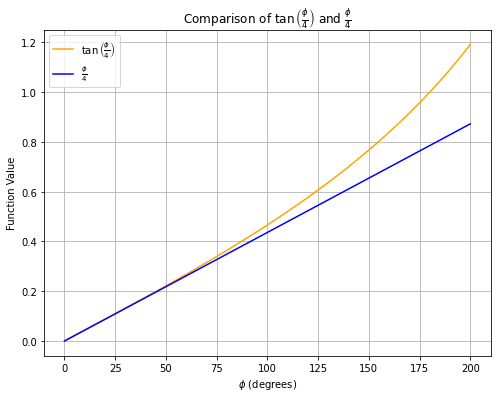

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Use inline plotting to avoid JavaScript dependency
%matplotlib inline

# Define a narrower range of angles to "zoom in" on the difference
phi = np.linspace(0, 200, 500)  # Limiting to 100 degrees for a closer comparison

# Calculate tan(phi/4) and phi/4
tan_phi4 = np.tan(np.radians(phi / 4))
linear_phi4 = np.radians(phi / 4)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(phi, tan_phi4, label=r'$\tan\left(\frac{\phi}{4}\right)$', color='orange')
plt.plot(phi, linear_phi4, label=r'$\frac{\phi}{4}$', color='blue')
plt.xlabel(r'$\phi$ (degrees)')
plt.ylabel('Function Value')
plt.title(r'Comparison of $\tan\left(\frac{\phi}{4}\right)$ and $\frac{\phi}{4}$')
plt.legend()
plt.grid()
plt.show()

**<ins>CRP Relationship</ins>**  
MRPs and CRPs can be interconverted as follows:  
$$
q = \frac{2\sigma}{1 - \|\sigma\|^2}, \quad \sigma = \frac{q}{1 + \sqrt{1 + q^T q}}
$$

**<ins>Relationship to DCM</ins>**  
MRPs are related to the Direction Cosine Matrix (DCM) as follows:  
$$
[\tilde{\sigma}] = \frac{[C]^T - [C]}{\zeta(\zeta + 2)}
$$
where,
$$\zeta = \sqrt{\text{trace}([C]) + 1} = \beta_0 / 2$$ 

The MRP vector $\sigma$ components in terms of DCM elements $C_{ij}$ are:  
$$
\sigma = \begin{pmatrix} \sigma_1 \\ \sigma_2 \\ \sigma_3 \end{pmatrix} = \frac{1}{\zeta(\zeta + 2)} \begin{pmatrix} C_{23} - C_{32} \\ C_{31} - C_{13} \\ C_{12} - C_{21} \end{pmatrix}
$$

**<ins>Advantages of MRPs</ins>**  
The key advantage of MRPs is their ability to shift the singularity from 180° (as in CRPs) to 360°. This means MRPs can handle complete 360° rotations, making them more robust in applications involving large rotations. Additionally, MRPs linearize well, which is beneficial for control and feedback applications where linearized models are preferred. For instance, the MRP relationship to PRV provides a linear approximation to angles, allowing for better performance in large-angle feedback systems.

MRPs are particularly useful in applications that require **non-singular attitude representations** for rotations approaching 360°, which can be challenging to handle with other parametrizations such as quaternions or CRPs.

#### 3.4.1.1 - Stereographic Projection of MRP

<div align="center">
  <img src="Images/MRP Stereographic Projection Slide.png" alt="Alt text" width="750"/>
</div>

In three-dimensional rotational dynamics, **stereographic projection** provides a method to map rotation states on a sphere (the set of Euler parameters) onto a plane, thereby facilitating the representation of orientations as Modified Rodrigues Parameters (MRPs). This technique is especially useful in avoiding the 180° singularity observed in Classical Rodrigues Parameters (CRPs) by shifting the singularity to a full 360° rotation.

**<ins>Projection Setup</ins>**  
- **Projection Point**: Located at $(-1, 0, 0, 0)$ along the $\beta_0$ axis.
- **Projection Plane**: Defined by $\beta_0 = 0$, serving as the hyperplane onto which points from the unit sphere (the set of rotation states) are projected.

By using this projection setup, any point on the sphere can be mapped onto the hyperplane to define a unique MRP vector.

**<ins>Projection Process</ins>**  
1. Take any point on thhypere **unit sphere** representing an attitude or rotation.
2. Draw a line from the **projection point** (at $(-1, 0, 0, 0)$) through this poihypernt on the sphere.
3. Locate the **intersection** of this li 3D hyperprojection plane ($\beta_0 = 0$). The coordinates of this intersection give the MRP vector $\sigma$, effectively representing the rotation in a compact and continuous manner.

**<ins>Key Properties</ins>**  
- **Linearization of MRPs**: MRPs provide a nearly linear approximation for rotation angles up to approximately 180°, making them advantageous for control applications where smooth transitions are needed.
- **Singularity Shift to 360°**: Unlike CRPs, which are singular at 180°, MRPs are only singular at 360° rotations, offering a wider range of continuous rotation representation.

**<ins>Practical Implications</ins>**  
This projection method enables efficient and robust attitude representation in control systems, as it allows the **norm of the MRP vector** to indicate rotation size:
  - If $\| \sigma \| < 1$, the rotation is less than 180°.
  - If $\| \sigma \| = 1$, the rotation is exactly 180°.
  - If $\| \sigma \| > 1$, the rotation exceeds 180° (indicating a long rotation).

The **stereographic projection** approach with MRPs thus provides an intuitive and manageable way to represent 3D orientations, minimizing singularities and maintaining continuity across a wide range of rotational states.


#### 3.4.1.2 - Shadow MRP Set

In cases where an MRP norm $\|\sigma\|$ exceeds 1 (i.e., describing a "long" rotation over 180°), we switch to the **Shadow MRP Set** to avoid singularities. The shadow MRPs, $\sigma^S$, provide an alternate representation, ensuring stable attitude descriptions.

**Definition of Shadow MRPs**  
Using the alternate set of Euler parameters, the shadow MRPs are defined as:
$$
\sigma_i^S = -\frac{\beta_i}{1 - \beta_0} = -\frac{\sigma_i}{\sigma^2}, \quad i = 1, 2, 3
$$

**Switching Criterion**  
A common surface for switching between the primary and shadow MRP sets is $\sigma \cdot \sigma = 1$, with conditions as follows:
- $\|\sigma\| \leq 1$ for $\Phi \leq 180^\circ$
- $\|\sigma\| \geq 1$ for $\Phi \geq 180^\circ$
- $\|\sigma\| = 1$ for $\Phi = 180^\circ$

**Shadow MRP Calculation**  
When the principal rotation angle $\Phi$ exceeds 180°, the shadow MRP vector $\sigma^S$ is calculated as:
$$
\sigma^S = \tan \left( \frac{\Phi - 2\pi}{4} \right) \hat{e}
$$
where $\hat{e}$ is the unit vector along the rotation axis.

If $\Phi' \leq 180^\circ$, the shadow MRP representation linearizes to:
$$
\sigma^S \approx \left( \frac{\Phi'}{4} \right) \hat{e}
$$
By switching to the shadow set when $\|\sigma\| > 1$, we maintain a bounded and well-behaved MRP description throughout all rotations, avoiding instability at $\Phi = 360^\circ$.


<div align="center">
  <img src="Images/MRP Shadow Set.png" alt="Alt text" width="750"/>
</div>

**<ins>Visualizing the Shadow Set of MRPs</ins>**  

Imagine an MRP unit sphere centered at the origin in three-dimensional space. This sphere represents all possible rotation states that can be described using MRPs, with the surface of the sphere corresponding to rotations of exactly 180 degrees.

**<ins>Primary MRPs Within the Unit Sphere</ins>**  
- **Rotations Less Than 180 Degrees:**  
  - When the rotation angle is less than 180 degrees, the MRPs have a norm (magnitude) less than 1.
  - These MRPs are represented as points inside the MRP unit sphere.
  - As the rotation angle increases from 0 to 180 degrees, the MRP vector moves from the origin toward the surface of the sphere.

**<ins>Rotations Exceeding 180 Degrees</ins>**  
- **Challenge for MRPs Beyond 180 Degrees:**  
  - For rotations greater than 180 degrees, the MRPs would have a norm greater than 1 if we continued using the same parameterization.
  - This would place the MRP vector outside the unit sphere, leading to computational issues and instability.

**<ins>Introducing the Shadow Set</ins>**  
- **Solution to Extend Beyond 180 Degrees:**  
  - Instead of allowing MRPs to exceed a norm of 1, we switch to the **Shadow Set** when the norm reaches 1.
  - The Shadow Set maps the MRPs back inside the unit sphere, ensuring the norm remains less than 1.
  - This allows for a continuous and smooth representation of rotations beyond 180 degrees.

**<ins>How the Shadow Set Works</ins>**  
- **Transition Between Primary and Shadow Sets:**  
  - As the MRP norm reaches 1 at a 180-degree rotation, the Shadow Set takes over to represent rotations beyond this angle.
  - The Shadow Set essentially “reflects” the MRP vector back inside the unit sphere, keeping the representation within the boundary.

**<ins>Visualization of Shadow Set Transition</ins>**  
- **Grey Line and Black Line:**  
  - The **grey line** represents the primary MRP set, which describes the rotation until it approaches 180 degrees (norm = 1).
  - At 180 degrees, the MRP vector moves to the **black line**, representing the Shadow Set, which smoothly continues the rotation description.
  - This transition avoids the singularity at 360 degrees, allowing MRPs to represent any rotation without instability.

**<ins>Key Points</ins>**  
- **Rotation Representation Remains Within the Sphere:**  
  - The Shadow Set ensures that the MRP vector stays within the unit sphere regardless of the rotation angle.
- **Continuous Representation:**  
  - By switching to the Shadow Set at 180 degrees, we avoid any jumps or discontinuities in the representation.

**<ins>Why Use the Shadow Set?</ins>**  
- **Avoiding Singularities**  
  - **Singularity at 360 Degrees:** MRPs have a singularity at a rotation of exactly 360 degrees, which is avoided by using the Shadow Set to switch smoothly at 180 degrees.
  - **Maintaining Stability:** Keeping the MRPs within the unit sphere (norm less than 1) ensures numerical stability and avoids computational issues.
- **Consistent Parameter Range**  
  - **Bounded Parameters:** The parameters remain bounded between -1 and 1, simplifying algorithms that use MRPs.
  - **Ease of Implementation:** Control systems and simulations can handle MRPs more efficiently when their magnitude is limited.
iciently when their magnitude is limited.


### 3.4.2 - Relationship to DCMs

**<ins>Matrix Components</ins>**  
The Direction Cosine Matrix (DCM), denoted as $[C]$, is defined as:
$$
[C] = \frac{1}{(1 + \sigma^2)^2} \begin{bmatrix} 
4 (\sigma_1^2 - \sigma_2^2 - \sigma_3^2) + (1 - \sigma^2)^2 & 8 \sigma_1 \sigma_2 + 4 \sigma_3 (1 - \sigma^2) & 8 \sigma_1 \sigma_3 - 4 \sigma_2 (1 - \sigma^2) \\ 
8 \sigma_1 \sigma_2 - 4 \sigma_3 (1 - \sigma^2) & 4 (- \sigma_1^2 + \sigma_2^2 - \sigma_3^2) + (1 - \sigma^2)^2 & 8 \sigma_2 \sigma_3 + 4 \sigma_1 (1 - \sigma^2) \\ 
8 \sigma_3 \sigma_1 + 4 \sigma_2 (1 - \sigma^2) & 8 \sigma_3 \sigma_2 - 4 \sigma_1 (1 - \sigma^2) & 4 (- \sigma_1^2 - \sigma_2^2 + \sigma_3^2) + (1 - \sigma^2)^2 
\end{bmatrix}
$$
This matrix provides a mapping from Modified Rodrigues Parameters (MRPs) to the DCM, allowing for a direct transformation between MRP space and rotational matrices.

**<ins>Vector Computation</ins>**  
An alternative vector-based formulation is:
$$
[C] = [I_{3 \times 3}] + \frac{8 \left[\tilde{\sigma}\right]^2 - 4 (1 - \sigma^2) \left[\tilde{\sigma}\right]}{(1 + \sigma^2)^2}
$$

where $\tilde{\sigma}$ represents the skew-symmetric matrix form of the MRP vector $\sigma$, providing an efficient way to compute $[C]$ from MRPs.

**<ins>Properties</ins>**  
1. **Transpose and Inverse Relation**: The inverse of the DCM is identical to its transpose and can be expressed as:
   $$
   [C(\sigma)]^{-1} = [C(\sigma)]^T = [C(-\sigma)]
   $$
   This property simplifies transformations between frames. For example, if $[C(\sigma)]$ represents a rotation from frame $N$ to frame $B$, then $[C(-\sigma)]$ represents the inverse rotation, from $B$ back to $N$, achieved by flipping the sign of the MRP vector.

2. **Ease of Inversion**: This relation enables straightforward computation of inverse transformations without recalculating complex angles. Unlike with Euler angles, where reversal requires recomputation, MRPs allow frame transformations by simply flipping the sign, maintaining computational simplicity.

3. **Pseudo-Vector Behavior**: Although MRPs are not true vectors, they exhibit pseudo-vector-like properties under specific transformations, which adds to their utility in representing rotations and simplifies certain attitude computations.

This DCM formulation offers a compact, computationally efficient representation for rotational dynamics, making it especially valuable in applications requiring frequent transformations between reference frames.

In [33]:
def MRP_to_DCM(sigma):
    """
    Converts a Modified Rodrigues Parameter (MRP) vector to a Direction Cosine Matrix (DCM).

    Args:
        sigma (numpy.ndarray): A 3-element array representing the MRP vector.

    Returns:
        numpy.ndarray: A 3x3 DCM matrix.
    """
    # Ensure sigma is a numpy array
    sigma = np.asarray(sigma).flatten()

    if sigma.shape[0] != 3:
        raise ValueError("Input sigma vector must be of length 3.")

    # Compute the Skew-Symmetric matrix of Sigma
    sigma_tilde = skew_symmetric(sigma)

    # 3x3 Identity Matrix
    I_3x3 = np.eye(3)

    # Comput the norm of MRP vector, sigma_squared
    sigma_squared = np.dot(sigma, sigma)

    # Vector Based Computation
    C = I_3x3 + ((8 * np.dot(sigma_tilde, sigma_tilde)) - (4 * (1 - sigma_squared) * sigma_tilde)) / ((1 + sigma_squared)**2)

    return C

# Example Usage:
phi = np.deg2rad(90)  # Convert 90 degrees to radians
e = np.array([0, 0, 1])  # Rotation axis (z-axis)
sigma = e * np.tan(phi / 4)
MRP_to_DCM(sigma)

array([[-2.22044605e-16,  1.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00, -2.22044605e-16,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [34]:
def DCM_to_MRP(C):
    """
    Converts a Direction Cosine Matrix (DCM) to a Modified Rodrigues Parameter (MRP) vector.

    Args:
        C (numpy.ndarray): A 3x3 DCM matrix.

    Returns:
        numpy.ndarray: A 3-element array representing the MRP vector (sigma).
    """
    # Ensure C is a numpy array
    C = np.asarray(C)
    if C.shape != (3, 3):
        raise ValueError("Input DCM must be a 3x3 matrix.")

    # Convert DCM to quaternion, [q0, q1, q2, q3]
    q = DCM_to_quaternion(C)  

    # Ensure quaternion is normalized
    #q = q / np.linalg.norm(q)

    # Extract scalar and vector parts
    q0 = q[0]  # Scalar part
    qv = q[1:]  # Vector part (3-element array)

    # Handle the case when q0 is negative to ensure |sigma| <= 1
    if q0 < 0:
        q0 = -q0
        qv = -qv

    # Compute MRP vector
    sigma = qv / (1 + q0)

    return sigma

# Define the DCM
C = np.array([[0, 1, 0],
              [-1,  0, 0],
              [0,  0, 1]])

# Compute the MRP vector
sigma = DCM_to_MRP(C)

print("MRP vector sigma:", sigma)

MRP vector sigma: [0.         0.         0.41421356]


In [35]:
MRP_to_DCM(np.array([0.1, 0.2, 0.3]))

array([[ 0.19975377,  0.91720529, -0.34472145],
       [-0.67097568,  0.38442598,  0.63404124],
       [ 0.71406587,  0.10464758,  0.69221299]])

In [36]:
C = np.array([[0.763314, 0.0946746, -0.639053],
              [-0.568047, -0.372781, -0.733728],
              [-0.307692, 0.923077, -0.230769]])

# Compute the MRP vector
sigma = DCM_to_MRP(C)

print("MRP vector sigma:", sigma)

MRP vector sigma: [-0.49999999  0.09999991  0.19999987]


### 3.4.3 - MRPs Addition/Subtraction

The Modified Rodrigues Parameters (MRPs) allow for computationally efficient attitude addition and subtraction without the need to map into and out of Direction Cosine Matrices (DCMs). This direct approach is particularly valuable in scenarios where the computational overhead of 3x3 matrix operations is a constraint.

**<ins>DCM Method</ins>**  
For addition and subtraction of attitudes, one method involves mapping the MRPs into DCMs, performing the matrix multiplication of the DCMs, and then converting the result back to the desired coordinate set. This method is computationally reliable but less efficient due to the matrix operations involved. The DCM method can be expressed as:
$$
[FN(\sigma)] = [FB(\sigma'')][BN(\sigma')]
$$
where:
- **σ′** represents the initial MRP rotation.
- **σ″** represents the additional MRP rotation applied to the initial rotation.

**<ins>Direct MRP Addition Property</ins>**  
A direct addition property exists for MRPs, bypassing the need for DCMs. The addition of two MRP rotations, **σ′** and **σ″**, can be represented as:
$$
\sigma = \frac{(1 - |\sigma'|^2)\sigma'' + (1 - |\sigma''|^2)\sigma' - 2\sigma'' \times \sigma'}{1 + |\sigma'|^2|\sigma''|^2 - 2\sigma' \cdot \sigma''}
$$
This formula provides a direct calculation of the combined attitude, avoiding the blow-up that occurs with CRPs when rotations sum to 180 degrees.

**<ins>Singularity Handling in MRP Addition</ins>**  
If two 180-degree rotations are added, resulting in a 360-degree rotation about the same axis, the denominator in the addition formula approaches zero, indicating a singularity. Since MRPs have a non-unique representation, this singularity can be handled by switching to the "shadow set." For example, adding a 180-degree rotation to another 180-degree rotation can be achieved by using a negative 180-degree rotation instead. This technique ensures a non-singular result, leveraging the flexibility of MRPs.

**<ins>Practical Implementation for Singularity Check</ins>**  
To avoid singularity, an `if` statement can be added to detect when the denominator is near zero. When this condition is met, the MRPs can be switched to their alternate set, thus preventing computational issues. This check does not need extreme precision; a tolerance near zero is sufficient to handle most cases.

**<ins>Subtraction of Attitude using MRPs</ins>**  
The subtraction of two attitudes can also be achieved directly in MRP space by using a negative MRP vector:
$$
\sigma'' = \frac{(1 - |\sigma'|^2)\sigma - (1 - |\sigma|^2)\sigma' + 2\sigma \times \sigma'}{1 + |\sigma'|^2|\sigma|^2 + 2\sigma \cdot \sigma'}
$$
Alternatively, subtracting **σ′** from **σ** is equivalent to adding **-σ′**. This symmetry allows for efficient computation of relative attitudes using the same addition formula by simply negating one of the MRPs.

**<ins>Advantages of Direct MRP Operations</ins>**  
The direct addition and subtraction formulas for MRPs offer significant computational advantages:
1. **Non-Singular Transformations**: The flexibility of switching to the shadow set eliminates singularities at 360 degrees, unlike CRPs.
2. **Computational Efficiency**: The direct approach avoids the overhead of DCM matrix operations, making it suitable for onboard computing with limited resources.
3. **Reliability**: For cases where precise numerical stability is critical, DCMs remain an option, though MRPs provide a faster and simpler alternative for most practical applications.

### 3.4.4 - MRPs Kinematic Differential Equation

**Differential Kinematic Equations for MRPs**  

The differential kinematic equation relates the attitude coordinate rates to angular velocity $\boldsymbol{\omega}$. The matrix component form of this equation is:

$$
\dot{\boldsymbol{\sigma}} = \frac{1}{4} \begin{bmatrix} 
1 - \sigma^2 + 2 \sigma_1^2 & 2 (\sigma_1 \sigma_2 - \sigma_3) & 2 (\sigma_1 \sigma_3 + \sigma_2) \\ 
2 (\sigma_2 \sigma_1 + \sigma_3) & 1 - \sigma^2 + 2 \sigma_2^2 & 2 (\sigma_2 \sigma_3 - \sigma_1) \\ 
2 (\sigma_3 \sigma_1 - \sigma_2) & 2 (\sigma_3 \sigma_2 + \sigma_1) & 1 - \sigma^2 + 2 \sigma_3^2 
\end{bmatrix} \boldsymbol{\omega^B}
$$

This form is computationally convenient, with a factor of $\frac{1}{4}$, allowing for efficient implementation in control systems.

**Vector Computation**  

Alternatively, the vector form of the equation is given by:
$$
\dot{\boldsymbol{\sigma}} = \frac{1}{4} \left[ (1 - \sigma^2) \boldsymbol{I}_{3 \times 3} + 2 \left[ \tilde{\sigma} \right] + 2 \boldsymbol{\sigma} \boldsymbol{\sigma}^T \right] \boldsymbol{\omega} = \frac{1}{4} [B(\sigma)] \boldsymbol{\omega}
$$
This form also contains only quadratic terms, with no division by zero issues, making it singular at $\Phi = \pm 360^\circ$.

**Inverting the Differential Kinematic Equation**  

To find $\boldsymbol{\omega}$ from $\dot{\boldsymbol{\sigma}}$, we invert the differential kinematic equation:
$$
\boldsymbol{\omega} = 4 [B]^{-1} \dot{\boldsymbol{\sigma}}
$$

The **near-orthogonality** of the $B$ matrix implies:
$$
[B]^{-1} = \frac{1}{(1 + \sigma^2)^2} [B]^T
$$
which simplifies inversion and provides the transformation:
$$
\boldsymbol{\omega} = \frac{4}{(1 + \sigma^2)^2} [B]^T \dot{\boldsymbol{\sigma}}
$$

**Efficient Integration Using Shadow Set Switching**  

For stable integration, switch to the **shadow set** when $\|\boldsymbol{\sigma}\| > 1$, representing rotations exceeding $180^\circ$. Implement this switch by setting:
$$
\boldsymbol{\sigma} = -\frac{\boldsymbol{\sigma}}{\sigma^2}
$$

This maintains the non-singular nature of MRPs during integration without requiring renormalization as in quaternions, thus simplifying the integration and maintaining computational efficiency.

### 3.4.5 - Cayley Transform 

### 3.4.6 - Visualizing MRPs 

In [37]:
def setup_animation_scene_2(fig, frames, title):
    play_button = {"label": 'Play',
                   "method": 'animate',
                   "args": [None, {"frame": {"duration": 50, "redraw": True},
                                   "fromcurrent": True,
                                   "mode": 'immediate'}]}

    slider_steps = [{"method": 'animate',
                     "args": [[f.name], {"mode": 'immediate',
                                         "frame": {"duration": 50, "redraw": True},
                                         "fromcurrent": True}],
                     "label": str(k)} for k, f in enumerate(frames)]

    fig.update_layout(updatemenus=[{"type": "buttons",
                                    "showactive": False,
                                    "y": -0.2,
                                    "x": 0.1,
                                    "xanchor": 'left',
                                    "yanchor": 'bottom',
                                    "buttons": [play_button]}],
                      sliders=[{"steps": slider_steps,
                                "x": 0.1,
                                "y": -0.25,
                                "currentvalue": {"visible": True, "prefix": 'Step: '}}],
                      width=800,
                      height=800,
                      template='presentation',
                      xaxis=dict(range=[-1.5, 1.5], scaleanchor="y", scaleratio=1, title='β₀ (Scalar Part)'),
                      yaxis=dict(range=[-3, 3], scaleanchor="x", scaleratio=1, title='β₁ (Vector Part)'),
                      title=title)

def MRP_visualization(steps=360):
    angles_deg = np.linspace(0, 360, steps + 1)
    angles_rad = np.deg2rad(angles_deg)
    
    quaternions = []
    mrps = []
    shadow_mrps = []

    for angle_rad in angles_rad:
        # Compute quaternion components
        beta_0 = np.cos(angle_rad / 2)
        beta_1 = np.sin(angle_rad / 2)
        beta_2 = 0.0
        beta_3 = 0.0
        quaternion = np.array([beta_0, beta_1, beta_2, beta_3])

        # Compute beta_i vector (vector part of quaternion)
        beta_i = np.array([beta_1, beta_2, beta_3])

        # Compute principal MRP
        if np.isclose(1 + beta_0, 0, atol=1e-6):
            mrp = np.array([np.inf, np.inf, np.inf])
        else:
            mrp = beta_i / (1 + beta_0)

        # Compute shadow MRP with negative sign
        if np.isclose(1 - beta_0, 0, atol=1e-6):
            shadow_mrp = np.array([np.inf, np.inf, np.inf])
        else:
            shadow_mrp = -beta_i / (1 - beta_0)

        quaternions.append(quaternion)
        mrps.append(mrp)
        shadow_mrps.append(shadow_mrp)

    # Generate unit circle
    circle_angles = np.linspace(0, 2 * np.pi, 100)
    circle_x, circle_y = np.cos(circle_angles), np.sin(circle_angles)

    # Initial values
    beta_0_init, beta_1_init, beta_2_init, beta_3_init = quaternions[0]
    mrp_init = mrps[0]
    shadow_mrp_init = shadow_mrps[0]
    angle_deg_init = angles_deg[0]

    # Prepare initial annotation
    annotation_text_init = (
        f"<b>Angle (φ):</b> {angle_deg_init:.2f}°<br>"
        f"<b>Angle (φ/2):</b> {angle_deg_init/2:.2f}°<br>"
        f"<b>Quaternion:</b> [β₀={beta_0_init:.2f}, β₁={beta_1_init:.2f}, β₂={beta_2_init:.2f}, β₃={beta_3_init:.2f}]<br>"
        f"<b>MRP:</b> [s₁={mrp_init[0]:.2f}, s₂={mrp_init[1]:.2f}, s₃={mrp_init[2]:.2f}]<br>"
        f"<b>Shadow MRP:</b> [s₁={shadow_mrp_init[0]:.2f}, s₂={shadow_mrp_init[1]:.2f}, s₃={shadow_mrp_init[2]:.2f}]"
    )

    # Initial data traces
    initial_data = [
        # Unit circle
        go.Scatter(x=circle_x,
                   y=circle_y,
                   mode='lines',
                   line=dict(color='blue'),
                   name='Unit Circle',
                   showlegend=True),
        
        # MRP Hyperplane at x = 0
        go.Scatter(x=[0, 0],
                   y=[-3, 3],
                   mode='lines',
                   line=dict(color='purple', dash='dash'),
                   name="Hyperplane (MRP)",
                   showlegend=True),
        
        # Projection source at (-1, 0)
        go.Scatter(x=[-1],
                   y=[0],
                   mode='markers',
                   marker=dict(color='black', size=8),
                   name='Projection Source',
                   showlegend=True),
        
        # Quaternion point
        go.Scatter(x=[beta_0_init],
                   y=[beta_1_init],
                   mode='markers',
                   marker=dict(color='orange', size=10),
                   name='Quaternion Point',
                   showlegend=True),

        # Projected point (principal MRP)
        go.Scatter(x=[0],
                   y=[mrp_init[0]],
                   mode='markers',
                   marker=dict(color='orange', size=10),
                   name='Projected Quaternion Point',
                   showlegend=True),

        # Projection line (principal MRP)
        go.Scatter(x=[-1, beta_0_init, 0],
                   y=[0, beta_1_init, mrp_init[0]],
                   mode='lines',
                   line=dict(color='orange', dash='dot'),
                   name='Projection Line (Quaternion Point)',
                   showlegend=True),
        
        # Alternate quaternion point
        go.Scatter(x=[-beta_0_init],
                   y=[-beta_1_init],
                   mode='markers',
                   marker=dict(color='darkblue', size=10),
                   name='Alternate Quaternion Point',
                   showlegend=True),
        
        # Shadow projected point
        go.Scatter(x=[0],
                   y=[shadow_mrp_init[0]],
                   mode='markers',
                   marker=dict(color='darkblue', size=10),
                   name='Shadow Set Projection',
                   showlegend=True),
        
        # Projection line (shadow MRP)
        go.Scatter(x=[-1, -beta_0_init, 0],
                   y=[0, -beta_1_init, -1e6],#shadow_mrp_init[0]],
                   mode='lines',
                   line=dict(color='darkblue', dash='dot'),
                   name='Projection Line (Shadow Set)',
                   showlegend=True),
    ]

    # Create the figure with the initial data and annotation
    fig = go.Figure(data=initial_data,
                    layout=go.Layout(annotations=[go.layout.Annotation(text=annotation_text_init,
                                                                       xref="paper", yref="paper",
                                                                       x=1.7, y=0.15,
                                                                       showarrow=False,
                                                                       align="left",
                                                                       bordercolor="black",
                                                                       borderwidth=1,
                                                                       borderpad=4,
                                                                       bgcolor="lightgrey",
                                                                       font=dict(size=12))]),
                    frames=[])

    frames = []
    for i, angle_deg in enumerate(angles_deg):
        beta_0, beta_1, beta_2, beta_3 = quaternions[i]
        beta_i = np.array([beta_1, beta_2, beta_3])
        mrp = mrps[i]
        shadow_mrp = shadow_mrps[i]

        # Determine singularities
        singularity_principal = np.isinf(mrp).any()
        singularity_shadow = np.isinf(shadow_mrp).any()

        # Principal MRP data
        if singularity_principal:
            x_projected_point = []
            y_projected_point = []
            x_projection_line = [-1, beta_0, beta_0]
            y_projection_line = [0, beta_1, 1e6]
        else:
            x_projected_point = [0]
            y_projected_point = [mrp[0]]
            x_projection_line = [-1, beta_0, 0]
            y_projection_line = [0, beta_1, mrp[0]]


        # Shadow MRP data
        if singularity_shadow:
            x_shadow_projected_point = []
            y_shadow_projected_point = []
            x_shadow_projection_line = [-1, -beta_0, -beta_0]
            y_shadow_projection_line = [0, -beta_1, -1e6]
        else:
            x_shadow_projected_point = [0]
            y_shadow_projected_point = [shadow_mrp[0]]
            x_shadow_projection_line = [-1, -beta_0, 0]
            y_shadow_projection_line = [0, -beta_1, shadow_mrp[0]]

        # Annotation Text
        annotation_text = (
            f"<b>Angle (φ):</b> {angle_deg:.2f}°<br>"
            f"<b>Angle (φ/2):</b> {angle_deg/2:.2f}°<br>"
            f"<b>Quaternion:</b> [β₀={beta_0:.2f}, β₁={beta_1:.2f}, β₂={beta_2:.2f}, β₃={beta_3:.2f}]<br>"
            f"<b>MRP:</b> [s₁={mrp[0]:.2f}, s₂={mrp[1]:.2f}, s₃={mrp[2]:.2f}]<br>"
            f"<b>Shadow MRP:</b> [s₁={shadow_mrp[0]:.2f}, s₂={shadow_mrp[1]:.2f}, s₃={shadow_mrp[2]:.2f}]"
            )

        if angle_deg < 150:
            annotation_text += "<br><span style='color:yellow;'><b>Using Principal MRP set</b></span>"
        elif 150 <= angle_deg < 180:
            annotation_text += "<br><span style='color:orange;'><b>Preparing to switch to shadow set</b></span>"
        elif angle_deg >= 180:
            annotation_text += "<br><span style='color:darkblue;'><b>Switched to shadow set!</b></span>"

        # Update the data of existing traces
        frame = go.Frame(
            data=[
                # Unit circle (no change)
                go.Scatter(),
                
                # MRP hyperplane (no change)
                go.Scatter(),
                
                # Projection source (no change)
                go.Scatter(),
                
                # Quaternion point
                go.Scatter(x=[beta_0], y=[beta_1]),

                # Projected point (principal MRP)
                go.Scatter(x=x_projected_point, y=y_projected_point),

                # Projection line (principal MRP)
                go.Scatter(x=x_projection_line, y=y_projection_line),
                
                # Alternate quaternion point
                go.Scatter(x=[-beta_0], y=[-beta_1]),
                
                # Shadow projected point
                go.Scatter(x=x_shadow_projected_point, y=y_shadow_projected_point),
                
                # Projection line (shadow MRP)
                go.Scatter(x=x_shadow_projection_line, y=y_shadow_projection_line),
            ],
            name=str(i),
            layout=go.Layout(annotations=[go.layout.Annotation(text=annotation_text,
                                                               xref="paper", yref="paper",
                                                               x=1.7, y=0.15,
                                                               showarrow=False,
                                                               align="left",
                                                               bordercolor="black",
                                                               borderwidth=1,
                                                               borderpad=4,
                                                               bgcolor="lightgrey",
                                                               font=dict(size=12))]))
        frames.append(frame)

    fig.frames = frames  # Add frames to the figure

    # Configure the layout using your existing setup_animation_scene function
    setup_animation_scene_2(fig, frames, "Quaternion Projection onto MRP Hyperplane")

    return fig

# Note: The setup_animation_scene function should be defined as in your existing code.

# Run the visualization
fig = MRP_visualization(steps=360)
fig.show()

## 3.5) Stereographic Orientation Parameters (SOPs)